# <center>Mundo Interconectado: Festival de Eurovisión</center>

<center> Sofía Maceín Sanz </center>

<center> Araceli Pérez Buendía </center>

# Índice

1. [Introducción](#introduccion)
2. [Resumen y objetivos](#resumen-y-objetivos)
3. [Análisis exploratorio de los datos](#analisis-exploratorio-de-los-datos)
4. [Análisis del grafo](#analisis-del-grafo)
   * [Métricas de la red](#metricas-de-la-red)
   * [Modelos de formación de redes](#modelos-formacion-redes)
   * [Análisis de comunidades](#analisis-de-comunidades)
   * [Evolución y dinámica](#evolucion-y-dinamica)
   
5. [Visualización mediante geolocalización](#visualización-mediante-geolocalizacion)
6. [Conclusiones](#conclusiones)

[Bibliografía](#bibliografia)

## 1. Introducción <a name="introduccion"></a>

El Festival de Eurovisión es una competición internacional de canciones organizada por la Unión Europea de Radiodifusión (UER), en la que participan países de toda Europa y, en ocasiones, de otras partes del mundo. Cada país envía una canción para competir, y los espectadores votan por sus favoritas a través de un sistema de puntos. La canción ganadora se decide mediante una combinación de votos de un jurado profesional y del público.  

El formato del concurso consta de tres programas en vivo: la Primera Semifinal, la Segunda Semifinal y la Gran Final. Los diferentes países compiten primero por un pase a la final donde se unen a las emisoras conocidas como los "Cinco Grandes" y a la Emisora Anfitriona (generalmente el país que ganó el año anterior). Los "Cinco Grandes" son: Francia, Alemania, Italia, España y Reino Unido. Se trata del grupo de países que realizan la mayor contribución financiera para la organización del concurso. 

Algunos puntos clave del concurso son:
* El evento se lleva a cabo anualmente desde 1956.
* Cada país debe llevar un artista o banda que lo represente cada año.
* El sistema de votación se divide en dos partes: los votos del jurado, conformado por expertos de la industria musical, y más recientemente, el televoto, que brinda al público la oportunidad de votar por su favorito a través de SMS, teléfono o la aplicación de Eurovisión.
* Un país (ya sea jurado o público) no puede votarse a sí mismo.
* Cada país vota por 12 de los 41 participantes. La primera opción recibe 12 puntos y la última recibe 1 punto.
* Sólo se anuncian los tres primeros puestos en la final.

La finalidad principal de Eurovisión es promover la música, la diversidad cultural y el entendimiento internacional a través de un evento de entretenimiento televisado a nivel mundial. Además, se considera como una oportunidad para fortalecer los lazos entre los países europeos, celebrando la diversidad y la unidad en un contexto de competición amistosa.

## 2.  Resumen y objetivos <a name="resumen-y-objetivos"></a>

En este estudio, se procede a realizar un análisis del concurso de Eurovisión utilizando técnicas de análisis de redes. Para ello, se emplea un conjunto de datos de acceso libre que incluye metadatos, clasificaciones del concurso y datos de votación de 1735 canciones que han participado en el Festival de la Canción de Eurovisión. Se prevé que la próxima versión de este conjunto de datos también incluya características de audio. Los metadatos y los datos de votación son proporcionados por el sitio web de fans de EurovisionWorld. En particular, la base de datos empleada se ha obtenido de Kaggle, donde se recopilan las votaciones del concurso en sus tres fases, tanto del jurado como del televoto, desde 1975 hasta 2019.

El objetivo principal es comprobar si existe algún tipo de sesgo en las votaciones. Para ello, se estudiará si las votaciones están influenciadas por afinidades culturales, la ubicación geográfica de los países o posibles acontecimientos políticos significativos.

## 3. Análisis exploratorio de los datos <a name="analisis-exploratorio-de-los-datos"></a>

Para iniciar el estudio, primero se procede a limpiar la base de datos con el fin de comprender la organización de los datos, identificar posibles valores atípicos y obtener una intuición inicial para el análisis posterior del grafo subyacente de la red. 

###  Paquetes y librerías

In [1]:
# Paquetes y librerias
import numpy as np 
import pandas as pd 
import re
import random
import json
import functools

# Visualizacion
from IPython.display import HTML
import pylab as plt
import seaborn as sns
import folium
from matplotlib.patches import Polygon, Rectangle

%matplotlib inline
sns.set_style('whitegrid')

# Grafos y redes
#!pip install python-louvain
import networkx as nx
import community as louvain

# Machine learning
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn import decomposition, manifold

from gensim.models import Word2Vec

# Advertencias
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Muchos algoritmos de grafos dependen de la semilla inicial
def setRandom():
    random.seed(42)
    np.random.seed(42)

setRandom()

### Carga de los datos 

En primer lugar, cargamos los datos y miramos la dimensión y la estructura.

In [3]:
# Dataset de eurovision
df = pd.read_excel('eurovision_1975_2019.xlsx')
df.columns = ['year','final','edition','votetype','countryfrom','countryto','points','duplicate'];

# Visualizacion dataset
df.sample(5)

,year,final,edition,votetype,countryfrom,countryto,points,duplicate
48675,2019,sf2,2019sf2,J,Malta,Azerbaijan,7,NaN
4657,1987,f,1987f,J,Luxembourg,Sweden,0,NaN
10539,1998,f,1998f,J,Malta,Turkey,0,NaN
30705,2013,f,2013f,J,France,Estonia,0,NaN
33401,2014,sf2,2014sf2,J,Ireland,Norway,8,NaN


In [4]:
# Dimension de los datos
df.shape

(49832, 8)

Existen 49832 registros de 8 variables.

In [5]:
# Valores de las columnas
for col in df.columns:
    print(col, ': ', sorted(df[col].dropna().unique()), '\n')

year :  [1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019] 

final :  ['f', 'sf', 'sf1', 'sf2'] 

edition :  ['1975f', '1976f', '1977f', '1978f', '1979f', '1980f', '1981f', '1982f', '1983f', '1984f', '1985f', '1986f', '1987f', '1988f', '1989f', '1990f', '1991f', '1992f', '1993f', '1994f', '1995f', '1996f', '1997f', '1998f', '1999f', '2000f', '2001f', '2002f', '2003f', '2004f', '2004sf', '2005f', '2005sf', '2006f', '2006sf', '2007f', '2007sf', '2008f', '2008sf1', '2008sf2', '2009f', '2009sf1', '2009sf2', '2010f', '2010sf1', '2010sf2', '2011f', '2011sf1', '2011sf2', '2012f', '2012sf1', '2012sf2', '2013f', '2013sf1', '2013sf2', '2014f', '2014sf1', '2014sf2', '2015f', '2015sf1', '2015sf2', '2016f', '2016sf1', '2016sf2', '2017f', '2017sf1', '2017sf2', '2018f', '2018sf1', '20

In [6]:
df.sample(5)

,year,final,edition,votetype,countryfrom,countryto,points,duplicate
13799,2004,f,2004f,J,Belarus,Albania,0,NaN
7610,1993,f,1993f,J,Italy,Bosnia & Herzegovina,3,NaN
8152,1994,f,1994f,J,Hungary,Slovakia,0,NaN
26400,2010,sf2,2010sf2,J,Denmark,Ukraine,3,NaN
21478,2008,f,2008f,J,Croatia,Norway,1,NaN


Las variables del dataset son las siguientes:

*   **`year`** : Representa el año en que se celebró el concurso. Los valores varían desde 1975 hasta 2019.
*   **`final`** : Indica si el registro corresponde a la final o a una de las semifinales del concurso.
*   **`edition`** : Representa la edición específica del evento de Eurovisión, indicada por el año y el tipo de ronda (final o semifinal).
*   **`votetype`** : Indica el tipo de voto utilizado en el evento, donde "J" representa el voto del jurado y "T" representa el televoto.
*   **`countryfrom`** : Indica el país de origen del voto.
*   **`countryto`** : Indica el país al que se dirige el voto.
*   **`points`** : Representa la cantidad de puntos asignados por un país a otro durante el proceso de votación. Los valores pueden variar de 0 y 8, 10 y 12.
*   **`duplicate`** : Esta variable marca con "x" aquellas filas donde el país de origen y el país de destino son iguales.

Vemos el tipo de variables y si existen valores nulos.

In [7]:
# Tipo de variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49832 entries, 0 to 49831
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   year         49832 non-null  int64 
 1   final        49832 non-null  object
 2   edition      49832 non-null  object
 3   votetype     49832 non-null  object
 4   countryfrom  49832 non-null  object
 5   countryto    49832 non-null  object
 6   points       49832 non-null  int64 
 7   duplicate    1528 non-null   object
dtypes: int64(2), object(6)
memory usage: 3.0+ MB


Por otra parte, se crea un diccionario con la localización geográfica de las capitales de los países participantes en el Festival con el fin de entender mejor cómo su ubicación geográfica en el contexto del análisis.

In [8]:
# Configuracion de la geolocalizacion
latLongFixed = pd.DataFrame.from_records(
[{'countryfrom': 'Albania', 'Capital': 'Tirane', 'Latitude': 41.3310413, 'Longitude': 19.7828036},
 {'countryfrom': 'Andorra', 'Capital': 'Andorra la Vella', 'Latitude': 42.5051006, 'Longitude': 1.5116108},
 {'countryfrom': 'Armenia', 'Capital': 'Yerevan', 'Latitude': 40.1535684, 'Longitude': 44.3484804},
 #{'countryfrom': 'Australia', 'Capital': 'Canberra', 'Latitude': -35.15, 'Longitude': 149.08},
  {'countryfrom': 'Australia', 'Capital': 'Canberra', 'Latitude': 36, 'Longitude': -19}, # localizacion falsa con fines visuales
 {'countryfrom': 'Austria',   'Capital': 'Vienna', 'Latitude': 48.2208286, 'Longitude': 16.2399746},
 {'countryfrom': 'Azerbaijan', 'Capital': 'Baku', 'Latitude': 40.3947695, 'Longitude': 49.714873},
 {'countryfrom': 'Belarus', 'Capital': 'Minsk', 'Latitude': 53.8847608, 'Longitude': 27.4532841},
 {'countryfrom': 'Belgium', 'Capital': 'Brussels', 'Latitude': 50.8550625, 'Longitude': 4.3053498},
 {'countryfrom': 'Bosnia', 'Capital': 'Sarajevo', 'Latitude': 43.8938852, 'Longitude': 18.2429054},
 {'countryfrom': 'Bulgaria', 'Capital': 'Sofia', 'Latitude': 42.6955992, 'Longitude': 23.1838604},
 {'countryfrom': 'Croatia', 'Capital': 'Zagreb', 'Latitude': 45.8403496, 'Longitude': 15.8242458},
 {'countryfrom': 'Cyprus', 'Capital': 'Nicosia', 'Latitude': 35.1923727, 'Longitude': 33.3273614},
 {'countryfrom': 'Czech Republic', 'Capital': 'Prague', 'Latitude': 50.0598058, 'Longitude': 14.3255389},
 {'countryfrom': 'Denmark', 'Capital': 'Copenhagen', 'Latitude': 55.6713442, 'Longitude': 12.523784},
 {'countryfrom': 'Estonia', 'Capital': 'Tallinn', 'Latitude': 59.4717421, 'Longitude': 24.4580607},
 {'countryfrom': 'Finland', 'Capital': 'Helsinki', 'Latitude': 60.11021, 'Longitude': 24.7385001},
 {'countryfrom': 'France', 'Capital': 'Paris', 'Latitude': 48.8589507, 'Longitude': 2.2770197},
 {'countryfrom': 'Georgia', 'Capital': "T'bilisi", 'Latitude': 41.7326304, 'Longitude': 44.6987664},
 {'countryfrom': 'Germany', 'Capital': 'Berlin', 'Latitude': 52.5069312, 'Longitude': 13.1445453},
 {'countryfrom': 'Greece', 'Capital': 'Athens', 'Latitude': 37.9909517, 'Longitude': 23.6682987},
 {'countryfrom': 'Hungary', 'Capital': 'Budapest', 'Latitude': 47.4813602, 'Longitude': 19.9902175},
 {'countryfrom': 'Iceland', 'Capital': 'Reykjavik', 'Latitude': 64.1335484, 'Longitude': -21.9224819},
 {'countryfrom': 'Ireland', 'Capital': 'Dublin', 'Latitude': 53.3244431, 'Longitude': -6.3857885},
 {'countryfrom': 'Israel', 'Capital': 'Jerusalem', 'Latitude': 31.7965337, 'Longitude': 35.0352712},
 {'countryfrom': 'Italy', 'Capital': 'Rome', 'Latitude': 41.9102415, 'Longitude': 12.3959115},
 {'countryfrom': 'Latvia', 'Capital': 'Riga', 'Latitude': 56.9715357, 'Longitude': 24.8489796},
 {'countryfrom': 'Lithuania', 'Capital': 'Vilnius', 'Latitude': 54.7007582, 'Longitude': 25.972849},
 {'countryfrom': 'Luxembourg', 'Capital': 'Luxembourg', 'Latitude': 49.6076951, 'Longitude': 6.0658298},
 {'countryfrom': 'Macedonia', 'Capital': 'Skopje', 'Latitude': 41.9991965, 'Longitude': 21.3548497},
 {'countryfrom': 'Malta',     'Capital': 'Valletta', 'Latitude': 35.8984976, 'Longitude': 14.5044102},
 {'countryfrom': 'Moldova', 'Capital': 'Chisinau', 'Latitude': 47.0000178, 'Longitude': 28.718091},
 {'countryfrom': 'Monaco',  'Capital': 'Monte Carlo', 'Latitude': 43.7410682, 'Longitude': 7.4172157},
 {'countryfrom': 'Montenegro', 'Capital': 'Montenegro', 'Latitude': 42.708679, 'Longitude': 19.37439},
 {'countryfrom': 'Morocco', 'Capital': 'Rabbat', 'Latitude': 31.791702, 'Longitude': -7.09262},
 {'countryfrom': 'Netherlands', 'Capital': 'Amsterdam', 'Latitude': 52.3547925, 'Longitude': 4.7638758},
 {'countryfrom': 'Norway',   'Capital': 'Oslo', 'Latitude': 59.8937803, 'Longitude': 10.6446921},
 {'countryfrom': 'Poland',   'Capital': 'Warsaw', 'Latitude': 52.2328546, 'Longitude': 20.9207684},
 {'countryfrom': 'Portugal', 'Capital': 'Lisbon', 'Latitude': 38.7436056, 'Longitude': -9.2304149},
 {'countryfrom': 'Romania',  'Capital': 'Bucuresti', 'Latitude': 44.4377397, 'Longitude': 25.9542107},
 {'countryfrom': 'Russia',   'Capital': 'Moskva', 'Latitude': 55.5807418, 'Longitude': 37.8237562},
 {'countryfrom': 'San Marino', 'Capital': 'San Marino', 'Latitude': 43.9428565, 'Longitude': 12.3898818},
 {'countryfrom': 'Serbia', 'Capital': 'Belgrade', 'Latitude': 44.8151593, 'Longitude': 20.2821702},
 {'countryfrom': 'Slovakia', 'Capital': 'Bratislava', 'Latitude': 48.1356948, 'Longitude': 16.9754907,},
 {'countryfrom': 'Slovenia', 'Capital': 'Ljubljana', 'Latitude': 46.0660959, 'Longitude': 14.4618877},
 {'countryfrom': 'Spain', 'Capital': 'Madrid', 'Latitude': 40.4378693, 'Longitude': -3.8199641,},
 {'countryfrom': 'Sweden', 'Capital': 'Stockholm', 'Latitude': 59.3260664, 'Longitude': 17.841628},
 {'countryfrom': 'Switzerland', 'Capital': 'Bern', 'Latitude': 46.9546485, 'Longitude': 7.3246587},
 {'countryfrom': 'Turkey', 'Capital': 'Ankara', 'Latitude': 39.9032919, 'Longitude': 32.6223372},
 {'countryfrom': 'Ukraine', 'Capital': 'Kiev', 'Latitude': 50.4016974, 'Longitude': 30.251825},
 {'countryfrom': 'United Kingdom', 'Capital': 'London', 'Latitude': 51.5285578, 'Longitude': -0.05}]
)

In [9]:
# Paises y fronteras
countriesCodes =['AE','AU','SA','SY','BE', 'EL','GR', 'LT', 'PT', 'BG', 'ES', 'LU', 'RO','GB','KZ','TM',
                 'CZ', 'FR', 'HU', 'SI', 'DK', 'HR', 'MT', 'SK', 'DE', 'IT', 'NL', 'FI','IQ',
                 'EE', 'CY', 'AT', 'SE', 'IE', 'LV', 'PL', 'UK', 'IS', 'NO', 'LI', 'CH','KW','OM',
                 'ME', 'MK', 'AL', 'RS', 'TR', 'BA', 'XK', 'AM', 'BY', 'GE', 'AZ', 'MD', 'UA', 'IR',
                 'IL', 'DZ', 'LB', 'SY', 'EG', 'LY', 'TN', 'IL', 'MA', 'RU', 'JO', 'PS','LB','PS','YE','JO','MT']


with open('custom.geo.json', encoding='utf-8') as file:
    countriesBorders = json.load(file)

In [10]:
# Relocalizacion de australia con fines visuales
ausCenter = pd.DataFrame(latLongFixed)[['Longitude','Latitude']].min().values+5
for n in countriesBorders['features']:
    if n['properties']['name']=='Australia':
        geometry = n['geometry'];
        if geometry['type'] == 'MultiPolygon':
            for c in geometry['coordinates']:
                for i in range(len(c)):
                    c[i] = ((np.array(c[i]) + np.array([-150,35]))/2+ausCenter).tolist()

In [11]:
# TODO: in a future relase this code will be replace by folium or other library
from matplotlib.patches import Polygon, Rectangle
def plotCountry(x, fill=False, fill_color='#fff'):
    coord = x['coordinates'];
    def draw(p):
        if len(p) < 2:
            return;
        p = np.array(p);
        plt.gca().plot(p[:,0],p[:,1],c='#cccccc', zorder=1)
        plt.gca().add_patch(Polygon(p,color=fill_color, zorder=1))
            
    if x['type'] == 'MultiPolygon':
        for p in coord:
            draw(p[0])
            
    if x['type'] == 'Polygon':
        draw(coord[0])

In [ ]:
# Mapa con folium
with open('custom.geo.json', encoding='utf-8') as file:
    countries_geojson = json.load(file)

# Crar el mapa
m = folium.Map(location=[0, 0], zoom_start=2)

# Añadir fronteras
folium.GeoJson(
    countries_geojson,
    name='geojson'
).add_to(m)

# Visualizacion
m

A continuación,

* Eliminamos del dataset los países que no están conectados dado un año, es decir, aquellos con puntuación `points` $ = 0$.
* Eliminamos las entradas marcadas como duplicadas, `duplicates` = 'x', que corresponenden a la unión del país consigo mismo.
* Renombramos algunos países para mayor facilidad
* Como para la construcción de la red final se tendrá en cuenta las ediciones a partir del año 2000, debido la incorporacion del televoto y la estabilidad política de los países, vamos a considerar los votos de Yugoslavia en sus correspondendientes estados actuales tras la disolución en 1992 (Bosnia y Herzegovina, Croacia, Eslovenia, Macedonia del Norte, Montenegro, Serbia, Kosovo).
* Eliminamos aquellos países con una baja participación, en particular, menor a 5 años o que no haya participado en los úlitmos 8 años.

Para todo esto, definimos una función `basicClean` en la que aplicamos los procedimientos explicados.

In [12]:
def basicClean(df, minYears = 5, last_participation = 8):

    # 1. ELiminamos puntuaciones de 0
    df2 = df.copy().query('points > 0')

    # 2. Eliminamos duplicados
    # Convertimos los valores 'x' a True y el resto a False
    df2['duplicate'] = df2['duplicate'].apply(lambda x: True if x == 'x' or x == True else False)
    # Nos quedamos con las filas en las que duplicate toma el valor False
    df2 = df2.query('duplicate == False').drop(columns=['duplicate'])


    # 3. Renombramos paises
    def applyRename(x):
        # Creamos un diccionario con los paises a renombrar
        renamings = {
            'North Macedonia': 'Macedonia',
            'F.Y.R. Macedonia': 'Macedonia',
            'The Netherands': 'Netherlands', # debido a un error en los datos
            'The Netherlands': 'Netherlands',
            'Bosnia & Herzegovina': 'Bosnia'}
        # Si el pais esta entre los paises del diccionario, cambiamos el nombre;
        # en caso contrario se devuelve el mismo nombre
        return renamings[x] if x in renamings else x

    # Aplicamos la funcion a las columnas con ls paises
    df2['countryfrom'] = df2['countryfrom'].apply(applyRename)
    df2['countryto']   = df2['countryto'].apply(applyRename)


    # 4. Division de Yugoslavia y Serbia & Montenegro a sus estados en la actualidad
    division = {
        'Yugoslavia': ['Macedonia', 'Serbia', 'Montenegro', 'Slovenia', 'Bosnia','Croatia'],
        'Serbia & Montenegro': ['Serbia', 'Montenegro']}

    df2['countryfrom'] = df2['countryfrom'].apply(lambda x:division[x] if x in division else x)
    df2['countryto']   = df2['countryto'].apply(lambda x:division[x] if x in division else x)

    df2 = df2.explode('countryfrom').explode('countryto')
    # Cada cambio que involucre a varios paises se desglosa entre los
    # pares de paises correspondientess


    # 5. Eliminamos aquellos paises que hayan participado menos 5 veces
    # y que no han estado activos en los ultimos 5 años

    # Calculamos numero de años participados y cuantos años han pasado desde
    # utlima participacion
    toKeep = df2.groupby('countryfrom').apply(lambda x:pd.Series(
        {'years': x['year'].nunique(),
        'last_participation': df2['year'].max() - x['year'].max()
    })).query(f'years >= {minYears} and last_participation <= {last_participation}').reset_index()['countryfrom']
    # Asi obtenemos la lista de paises que cumplen los requisitos

    # Mostramos los paises que no cumplen los requisitos
    display(HTML("<p>ignored countries: %s</p>" %', '.join(df2[df2['countryfrom'].isin(toKeep)==False]['countryfrom'].unique())))

    df2 = df2[df2['countryfrom'].isin(toKeep)]
    df2 = df2[df2['countryto'].isin(toKeep)]



    # 6. Tomamos los puntos unicamente de la final
    df2['finalcode'] = df2.final.map({'f':1, 'sf':2,'sf1':2,'sf2':2})
    temp1 = df2.groupby(['countryto','year']).agg({'finalcode':'min'});
    df2 = pd.merge(df2,temp1, on=['countryto','year','finalcode'], how='inner')

    assert len(df2.groupby(['countryfrom','countryto','year']).agg({'final':'nunique'}).query('final >1')) == 0

    df2.drop(columns=['finalcode','edition'], inplace=True)

    return df2.reindex()

In [13]:
# Aplicamos la funcion al dataset original
df2 = basicClean(df)

# Dimnesion del nuevo dataset
print('Dimension del nuevo dataset: ', df2.shape, '\n')

# Visualizacion del dataset
df2.sample(5)

Dimension del nuevo dataset:  (17199, 6) 



,year,final,votetype,countryfrom,countryto,points
8627,2007,f,J,Russia,Turkey,2
12833,2015,f,J,Portugal,Sweden,8
3156,1989,f,J,France,Denmark,6
14647,2017,f,T,Latvia,Norway,1
9899,2009,f,J,Switzerland,Israel,1


Ahora tenemos un dataset con 17199 registros y 6 variables.

### Exploración 

El objetivo de esta sección es estudiar la posible distribución subyecente de los datos, así como posibles outliers o valores atípicos. Con ello, pretendemos crear una red que recoja la información básica del concurso a lo largo de los años para dar respuesta a las preguntas planteadas.

In [14]:
# Dataset
df2.sample(5)

,year,final,votetype,countryfrom,countryto,points
6177,2000,f,J,Macedonia,Russia,7
5233,1996,f,J,Norway,Croatia,7
15059,2017,sf1,T,Moldova,Montenegro,8
2486,1986,f,J,Netherlands,Denmark,4
14682,2017,f,J,Netherlands,Sweden,6


**1) Tendencia en la participación a lo largo de los años:** Se muestra el número total de puntos otorgados a lo largo de los años en la categoría final de Eurovisión, proporcionando una perspectiva del crecimiento del evento y el interés continuo de los países.

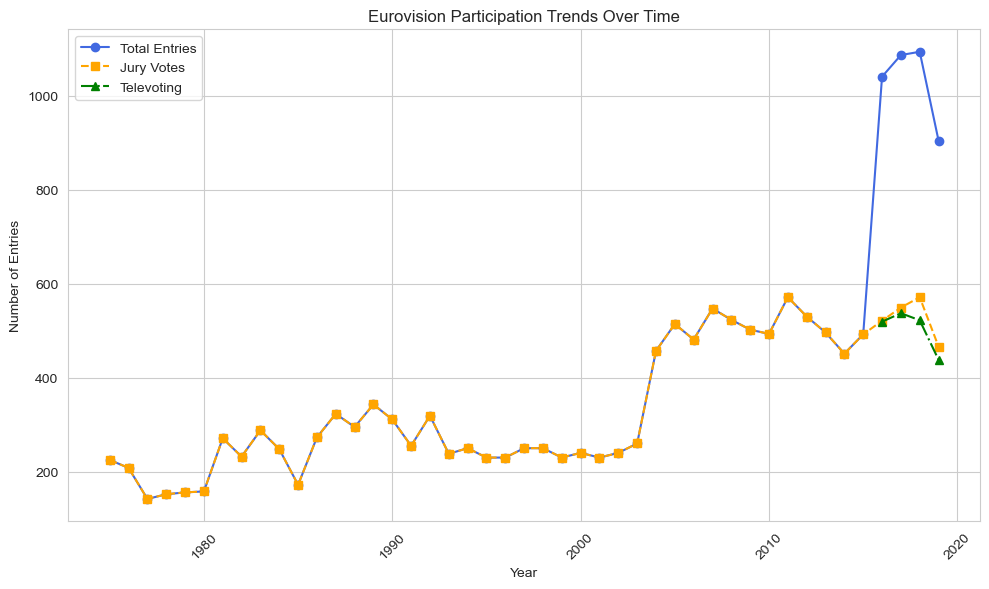

In [15]:
# Convertimos la columna 'year' a formato datetime
df2['year'] = pd.to_datetime(df2['year'], format='%Y')

# Agrupamos por año y contamos el número de entradas
participation_counts_total = df2.groupby(df2['year'].dt.year).size() # totales
participation_counts_J = df2[df2['votetype'] == 'J'].groupby(df2['year'].dt.year).size() # jurado
participation_counts_T = df2[df2['votetype'] == 'T'].groupby(df2['year'].dt.year).size() # televoto

# Grafico de las tendencias de participación
plt.figure(figsize=(10, 6))

participation_counts_total.plot(marker='o', color='royalblue', linestyle='-', label='Total Entries')
participation_counts_J.plot(marker='s', color='orange', linestyle='--', label='Jury Votes')
participation_counts_T.plot(marker='^', color='green', linestyle='-.', label='Televoting')

plt.title('Eurovision Participation Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Entries')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Breve explicación del aumento de votos:

* 1997-2008: Televoto
* 2009-2015: Sistema Mixto
* 2016 - Televoto(app)

Se puede observar cómo el fenómeno del concurso ha ido creciendo a lo largo de los años. Cabe destacar un salto en el año 2016, cuando se introdujo la aplicación oficial de Eurovisión. Esta innovación permitió a los espectadores votar por sus canciones favoritas durante las semifinales y la gran final utilizando sus teléfonos móviles.

**2) Distribución de puntos por país:** Histograma que visualiza la distribución de puntos recibidos por cada país. Esto puede proporcionar información sobre la equidad y consistencia del proceso de votación.

<Figure size 1200x800 with 0 Axes>

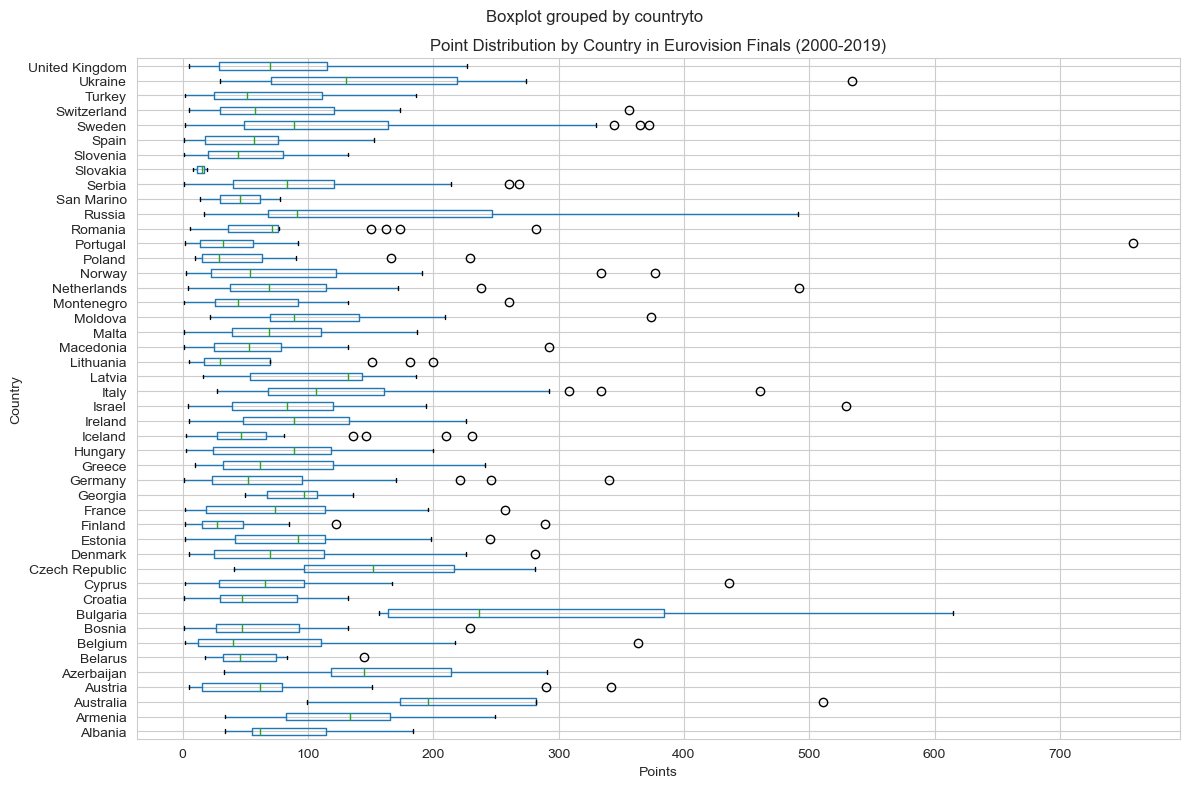

In [16]:
# Categoria de final (f)
df_final = df2[df2['final'] == 'f']
points_by_country_year = df_final.groupby(['countryto', df_final['year'].dt.year])['points'].sum().reset_index()

# Grafico boxplot
plt.figure(figsize=(12, 8))
boxplot = points_by_country_year.boxplot(column='points', by='countryto', vert=False, figsize=(12,8))

plt.title('Point Distribution by Country in Eurovision Finals (2000-2019)')
plt.xlabel('Points')
plt.ylabel('Country')
plt.grid(True)
plt.tight_layout()
plt.show()

En algunos países se observa una variabilidad considerable en la cantidad de puntos recibidos a lo largo de los años. Lo que significa que algunos años han sido más favoralbes en términos de puntuación recibida, y otros años menos favorables.

**3) Intercambio de puntos:** Identificar patrones de alianzas o amistades entre países, así como identificar grupos de países que con frecuencia se votan entre sí. Para lograrlo, se utiliza un mapa de calor que muestra el intercambio de puntos entre los países participantes.

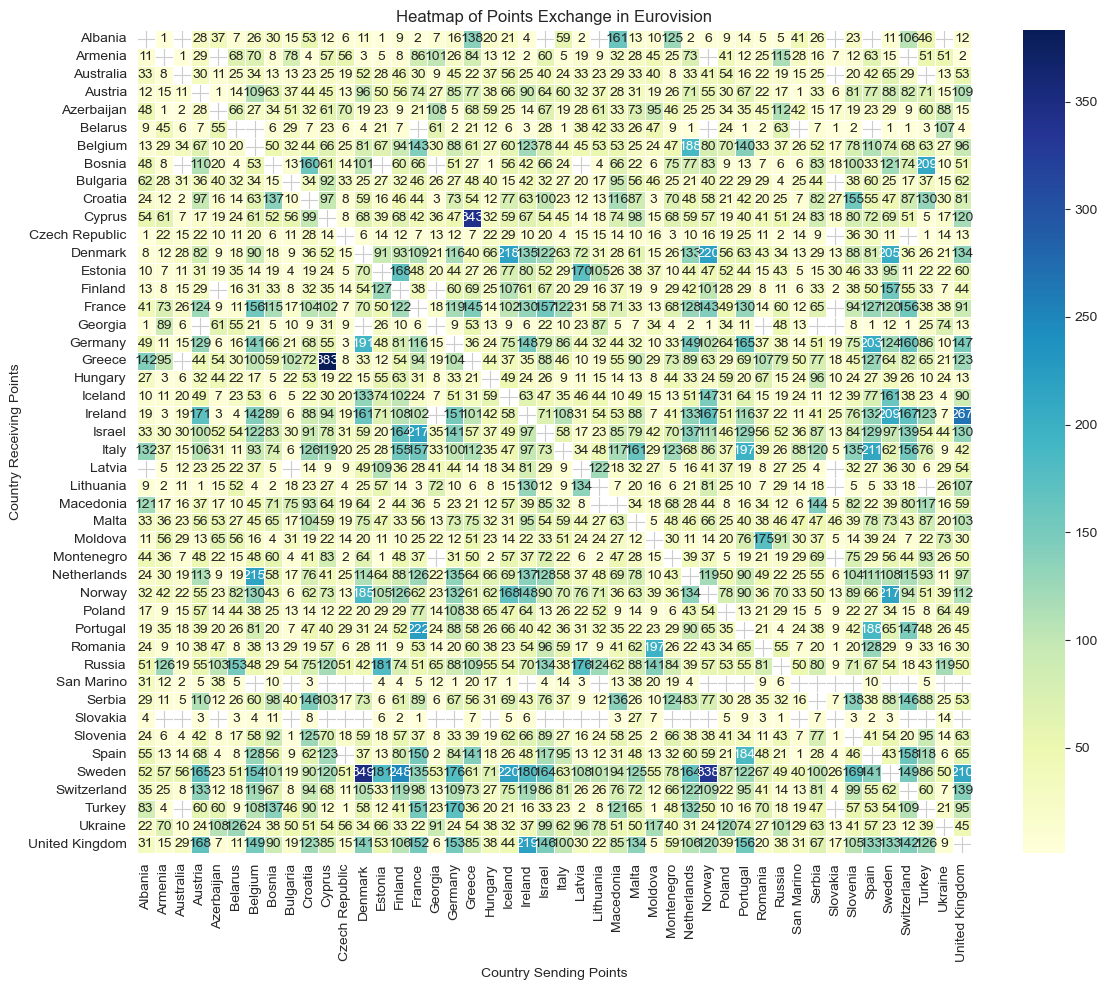

In [17]:
# Intercambio de puntos
points_matrix = df2.pivot_table(index='countryto', columns='countryfrom', values='points', aggfunc='sum')

# Grafico
plt.figure(figsize=(12, 10))
sns.heatmap(points_matrix, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5)
plt.title('Heatmap of Points Exchange in Eurovision')
plt.xlabel('Country Sending Points')
plt.ylabel('Country Receiving Points')
plt.tight_layout()
plt.show()

Se puede observar que países como Grecia y Chipre muestran una alta correlación en sus votaciones. Del mismo modo, existen otros bloques con una correlación significativa, como Suecia, Dinamarca y Noruega, y en menor medida Finlandia e Islandia; así como España y Portugal, o Irlanda y el Reino Unido. Por lo tanto, parece que la ubicación geográfica de los países y la afinidad cultural son factores influyentes en el intercambio de puntos entre ellos.

**4) Resumen de la participación por país en el concurso de Eurovisión**: incluyendo el número de años únicos en los que un país participó, el año más temprano de participación, el año más reciente de participación y el porcentaje de presencia, que representa la proporción de años en los que el país participó en relación con el número total de años disponibles.

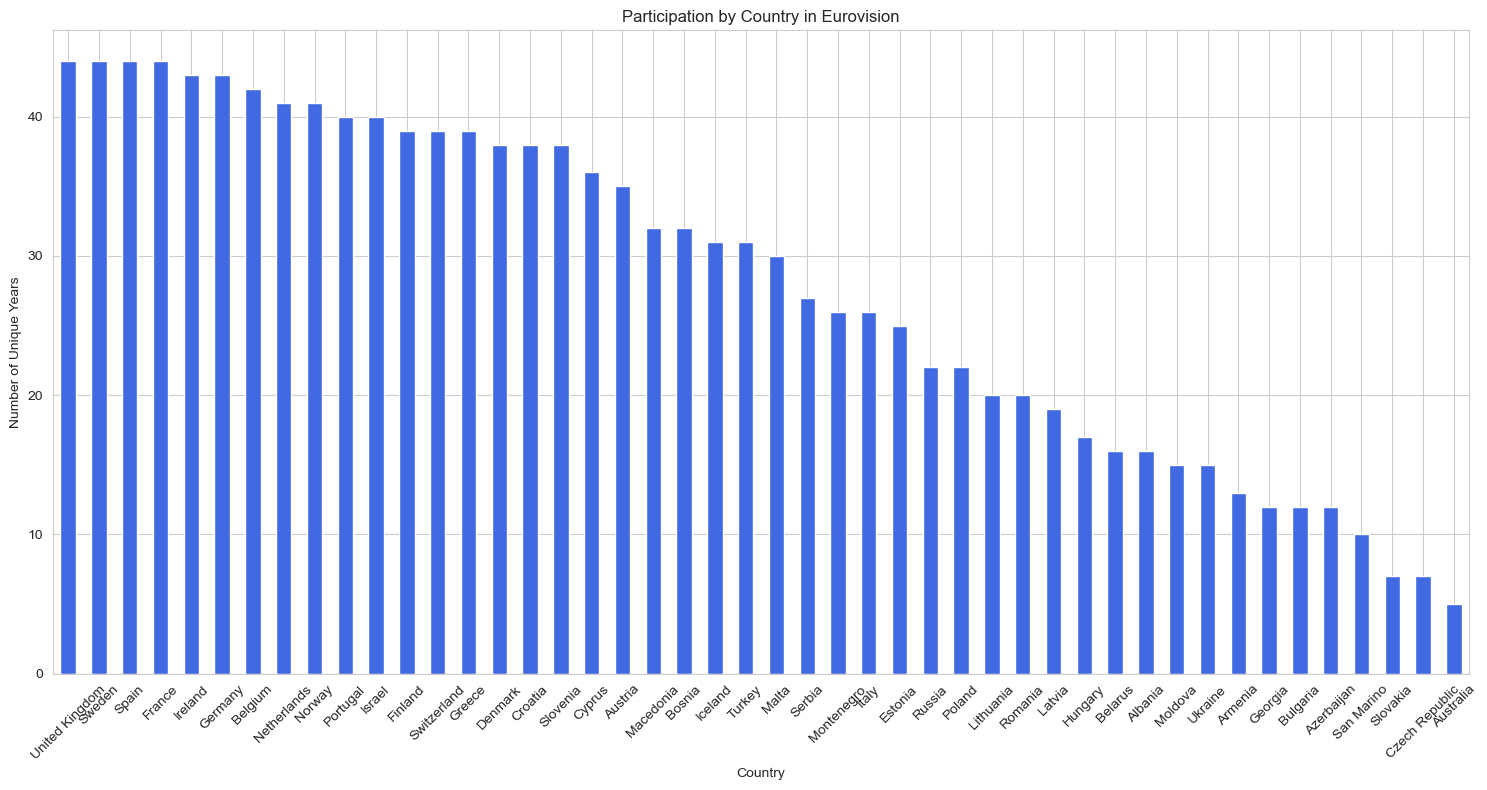

In [18]:
# Generate the summary of participation by country
participation_summary = df2.groupby(['countryto']).apply(lambda x: pd.Series({
    'nyear': x['year'].nunique(),
    'min_year': x['year'].min().year,
    'max_year': x['year'].max().year,
    'presence': int(100 * x['year'].nunique() / (x['year'].max().year - x['year'].min().year + 1))
}))

# Sort the summary by the number of unique years in descending order
participation_summary_sorted = participation_summary.sort_values('nyear', ascending=False)# Plot the participation by country as a bar chart
plt.figure(figsize=(15, 8))
participation_summary_sorted['nyear'].plot(kind='bar', color='royalblue')
plt.title('Participation by Country in Eurovision')
plt.xlabel('Country')
plt.ylabel('Number of Unique Years')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Podemos observar que algunos países, como Reino Unido, Suecia, España y Francia, han participado en casi todas las ediciones del concurso desde que comenzó en 1975. Esto se debe a que forman parte de los "Cinco Grandes".

Otros países, como Australia, han participado en un número menor de ediciones debido a su incorporación más reciente al concurso. Sin embargo, su tasa de presencia es del 100% en las ediciones en las que han participado.

Algunos países han disminuido su participación a lo largo de los años, como Turquía, que dejó de participar después de 2012, y Bosnia, que dejó de participar después de 2016. Esto puede deberse a varias razones, como cambios en las políticas de participación o problemas financieros.

**Ganadores**

In [20]:
# Resumen top 3 de las finales
df2.query('final =="f"')\
    .groupby(['countryto','year']).agg({'points':'sum'}).reset_index()\
    .groupby('year').apply(lambda x:x.sort_values('points').tail(1)).reset_index(drop=True)\
    .sort_values('year',ascending=False)\
    .head(12).T.style.set_caption("The Winners")

,44,43,42,41,40,39,38,37,36,35,34,33
countryto,Netherlands,Israel,Portugal,Ukraine,Sweden,Austria,Denmark,Sweden,Azerbaijan,Germany,Norway,Russia
year,2019-01-01 00:00:00,2018-01-01 00:00:00,2017-01-01 00:00:00,2016-01-01 00:00:00,2015-01-01 00:00:00,2014-01-01 00:00:00,2013-01-01 00:00:00,2012-01-01 00:00:00,2011-01-01 00:00:00,2010-01-01 00:00:00,2009-01-01 00:00:00,2008-01-01 00:00:00
points,492,529,758,534,365,290,281,372,221,246,377,267


Los países con las puntuaciones más altas en el Festival de Eurovisión en los últimos años han sido los Países Bajos, Israel, Portugal, Ucrania y Suecia

**Frecuencia con la que cada país aparece en la lista de los mejores países de Eurovisión en función de la cantidad de puntos recibidos en cada año y el número de posiciones superiores**

In [21]:
def atTop(df,tops):
    # points received
    df = df.groupby(['countryto','year']).agg({'points':'sum'}).reset_index().groupby('year')

    # top1 (country with most of points)
    top = df.apply(lambda x:x.sort_values('points').tail(1)).reset_index(drop=True)\
        .groupby('countryto').agg({'year':'nunique'}).rename(columns={'year':'years_on_top'}).reset_index()

    # the other tops
    for t in tops:
        temp = df.apply(lambda x:x.sort_values('points').tail(t)).reset_index(drop=True)\
            .groupby('countryto').agg({'year':'nunique'})\
            .rename(columns={'year':f'years_on_top_{t}'}).reset_index()
        top = pd.merge(top,temp, on='countryto',how='outer')

    top = top.fillna(0);
    floatcols = top.columns[top.dtypes == 'float64']
    top[floatcols] = top[floatcols].astype(int)

    return top

In [24]:
dfAtTop = atTop(df2.query('final =="f"'), tops=[3,5,7,10])
dfAtTop.sort_values(['years_on_top','years_on_top_3'], ascending=[False,False]).head(20)\
    .style.bar(subset=['years_on_top','years_on_top_3','years_on_top_5','years_on_top_7','years_on_top_10'],
               color='#cccccc')

,countryto,years_on_top,years_on_top_3,years_on_top_5,years_on_top_7,years_on_top_10
18,Sweden,5,12,19,25,29
9,Ireland,5,10,15,19,22
10,Israel,5,7,10,12,19
22,United Kingdom,4,10,15,18,23
6,France,3,6,12,16,21
14,Norway,3,5,10,11,16
7,Germany,2,8,12,14,21
21,Ukraine,2,5,6,8,9
3,Denmark,2,4,7,10,13
16,Russia,1,8,10,11,13


Vemos que países como Suecia, Irlanda, Noruega y Dinamarca tienen una presencia notable en las posiciones superiores, lo que sugiere un dominio continuo en el concurso de Eurovisión.

Países como Israel, Francia, Alemania y Ucrania muestran una presencia intermitente en las posiciones superiores, lo que indica un éxito variable a lo largo de los años.

La mayoría de los países tienen al menos una aparición en las posiciones superiores, lo que sugiere una distribución relativamente equitativa del éxito en Eurovisión entre varios países.

**5) Preferencias de voto de España hacia diferentes países en el Festival de Eurovisión, desglosadas por los diferentes tipos de votos**:
El jurado puede influir más en el resultado que el público (televoto) y, en muchos casos, es clara la diferencia en sus preferencias.

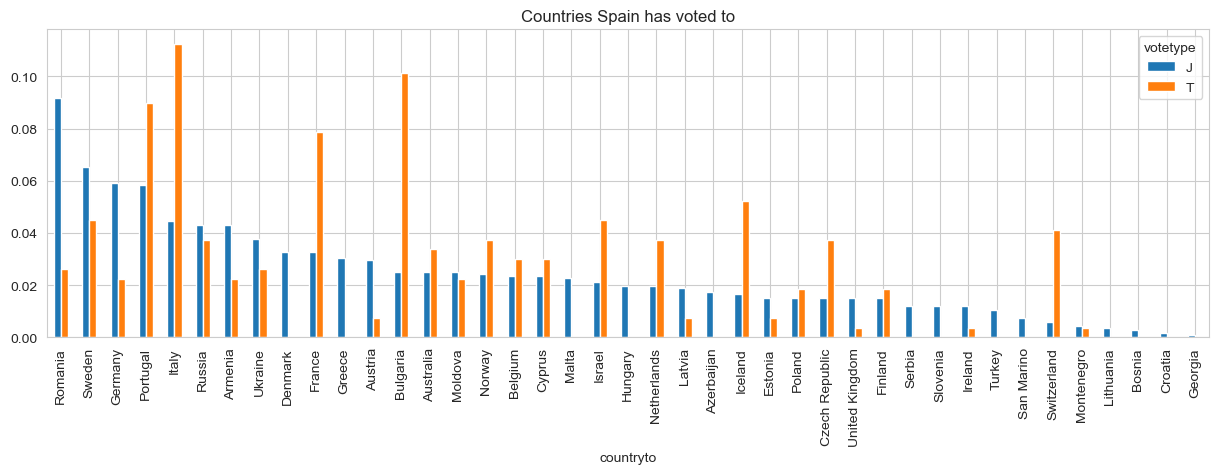

In [25]:
# Desglose de votaciones de España a partir del 2000
df2 \
    .query('year >= 2000 and countryfrom=="Spain"')\
    .pivot_table(index='countryto',columns='votetype', values='points',aggfunc='sum').fillna(0).sort_values('J',ascending=False)\
    .apply(lambda x: x/x.sum(), axis=0)\
    .plot(kind='bar',stacked=False,figsize=(15,4), title='Countries Spain has voted to');
plt.grid('off')
plt.show()

## 4. Análisis del grafo <a name="analisis-del-grafo"></a>

En esta sección, se plantea el estudio utilizando un modelo de grafos dirigidos. En este contexto, los nodos representan los diferentes países participantes en el concurso de Eurovisión, mientras que las aristas dirigidas representan las relaciones de votación entre estos países. Además, se asigna un peso a cada arista basado en las puntuaciones recibidas durante el concurso. Este enfoque nos permite explorar las relaciones de votación, identificar patrones de afinidad cultural y evaluar la influencia de diferentes factores en los resultados finales.

In [26]:
# Funciones de selecciones de porcentaje
def selectTopN(x, column, top=3):
    x = x.sort_values(column, ascending=False).head(top)
    return x

def selectTopPercent(x, column, percent=0.3, retrieve_first=True):
    x = x.sort_values(column, ascending=False)
    cut = x[column].cumsum() / x[column].sum()
    cut = cut <= percent

    # Return at least the first and avoid warnings
    if retrieve_first and cut.sum() == 0:
        return x.iloc[0]

    return x[cut]


Visualizamos el grafo resultante de la agregación de votos y televotos en la fase final del Festival de Eurovisión, organizado por año.

In [28]:
# Funcion para normalizar las puntuaciones
def normalizer(x):
    # Dividimos la puntuacion por la suma total de los puntos
    x['points'] = x['points']/x['points'].sum()
    return x

# Funcion para asignar las puntuaciones
def assign_scores(df, year):
    df_year = df2[df2['year'].dt.year == year]\
        .query('final=="f"')\
        .groupby(['countryfrom','countryto'])\
        .agg({'points':'sum'}).reset_index()\
        .groupby('countryfrom').apply(normalizer).reset_index(drop=True)\
        .rename(columns={'points':'weight'})
    
    return df_year

# Funcion para crear el grafo dirigido de un año 
def plot_eurovision_graph(df, year, percent = 0.3, show_plots = True):
    # Agregar el televoto y el voto del jurado
    df_year = assign_scores(df, year)

    # Crear el grafo original con todas las conexiones
    G = nx.from_pandas_edgelist(df_year, 'countryfrom', 'countryto', ['weight'], create_using=nx.DiGraph)
    pos1 = nx.circular_layout(G) # layout del primer grafo

    # Crear el segundo grafo con el porcentaje de los pesos mas altos
    selected_edges = selectTopPercent(df_year, 'weight', percent=percent)
    G2 = nx.from_pandas_edgelist(selected_edges, 'countryfrom', 'countryto', ['weight'], create_using=nx.DiGraph)
    pos2 = nx.kamada_kawai_layout(G2, weight='weight') # layout del segundo grafo

    # Graficos
    if show_plots:
        fig, axs = plt.subplots(1, 2, figsize=(16, 8))

        # Grafo original
        nx.draw(G, pos1, ax=axs[0], with_labels=True, node_color=list(nx.pagerank(G).values()),
                cmap=plt.cm.viridis_r, edge_color='#cccccc', font_color='#000', font_size=10, font_weight='bold', arrows=True)
        axs[0].set_title(f'Directed Graph of Points Exchange in Eurovision {year} (Original)')
        axs[0].axis('off')

        # Grafo con el porcentaje seleccionado
        nx.draw(G2, pos2, ax=axs[1], with_labels=True, node_color=list(nx.pagerank(G2).values()),
                cmap=plt.cm.viridis_r, edge_color='#cccccc', font_color='#000', font_size=10, font_weight='bold', arrows=True)
        axs[1].set_title(f'Directed Graph of Points Exchange in Eurovision {year} (30% of Edge Weight)')
        axs[1].axis('off')


        plt.tight_layout()
        plt.show()

    return df_year, selected_edges, G, G2

In [ ]:
# Final 2019
plot_eurovision_graph(df2, 2019, percent=0.3)

### 4.1. Métricas de la red <a name="metricas-de-la-red"></a>

En primer lugar, se procede a analizar las diversas métricas de la red estática, es decir para un año en concreto, con el propósito de evaluar su capacidad para representar y explicar la realidad estructural. Esto permite examinar la relevancia de las interacciones entre los nodos, así como la información estructural que proporcionan. Además, se busca caracterizar la complejidad del modelo, considerando la completitud del mismo en la representación de las relaciones entre los elementos de la red.

In [29]:
# Funcion para calcular las metricas de una red dado un año
def network_metrics(df, year, show_plots=True):
    # Filtrar año especifico
    df_year, edges_year, G_year, Gedges_year = plot_eurovision_graph(df, year, 0.3, show_plots)

    # Almacenamiento de las metricas
    metrics = {}
    
    # Numero de nodos y enlaces
    metrics['nodes'] = G_year.number_of_nodes()
    metrics['edges'] = G_year.number_of_edges()
    
    # Densidad
    metrics['density'] = nx.density(G_year)
    
    # Grado
    metrics['in_degree'] = G_year.in_degree()  # grado de entrada
    
    # Distribucion de grado
    if show_plots:
        plt.figure(figsize=(8, 6))
        plt.hist(dict(G_year.in_degree()).values())
        plt.title(f'Degree Distribution - Eurovision {year}')
        plt.show() 
    
    # PageRank
    metrics['page_rank'] = nx.pagerank(G_year, weight='weight', max_iter=1000)
    
    # Componente gigante
    largest_component = max(nx.strongly_connected_components(G_year), key=len)
    metrics['largest_component'] = G_year.subgraph(largest_component).copy()
    
    # Diametro
    metrics['diameter'] = nx.diameter(metrics['largest_component'])
    
    # Grafico componente gigante
    if show_plots:
        plt.figure(figsize=(8, 6))
        pos = nx.kamada_kawai_layout(metrics['largest_component'])
        nx.draw(metrics['largest_component'], pos, with_labels=True, node_color='#87CEEB',
            edge_color='#cccccc', font_color='#000', font_size=10, font_weight='bold', arrows=True)
        plt.title(f'Largest Strongly Connected Component - Eurovision {year}')
        plt.axis('off')
        plt.show()
    
    # Centralidad de intermediacion
    metrics['betweenness_centrality'] = nx.betweenness_centrality(G_year)
    
    # Centralidad de cercania
    metrics['closeness_centrality'] = nx.closeness_centrality(G_year)
    
    # Centralidad de grado
    metrics['degree_centrality'] = nx.degree_centrality(G_year)
    
    # Transitividad
    metrics['transitivity'] = nx.transitivity(G_year)
    
    # Longitud promedio del camino mas corto
    metrics['average_shortest_path_length'] = nx.average_shortest_path_length(metrics['largest_component'])
    
    # Coeficiente de clustering
    metrics['clustering_coefficient'] = nx.average_clustering(G_year)
    
    return df_year, edges_year, G_year, Gedges_year, metrics

**Métricas de la red para el año 2019**

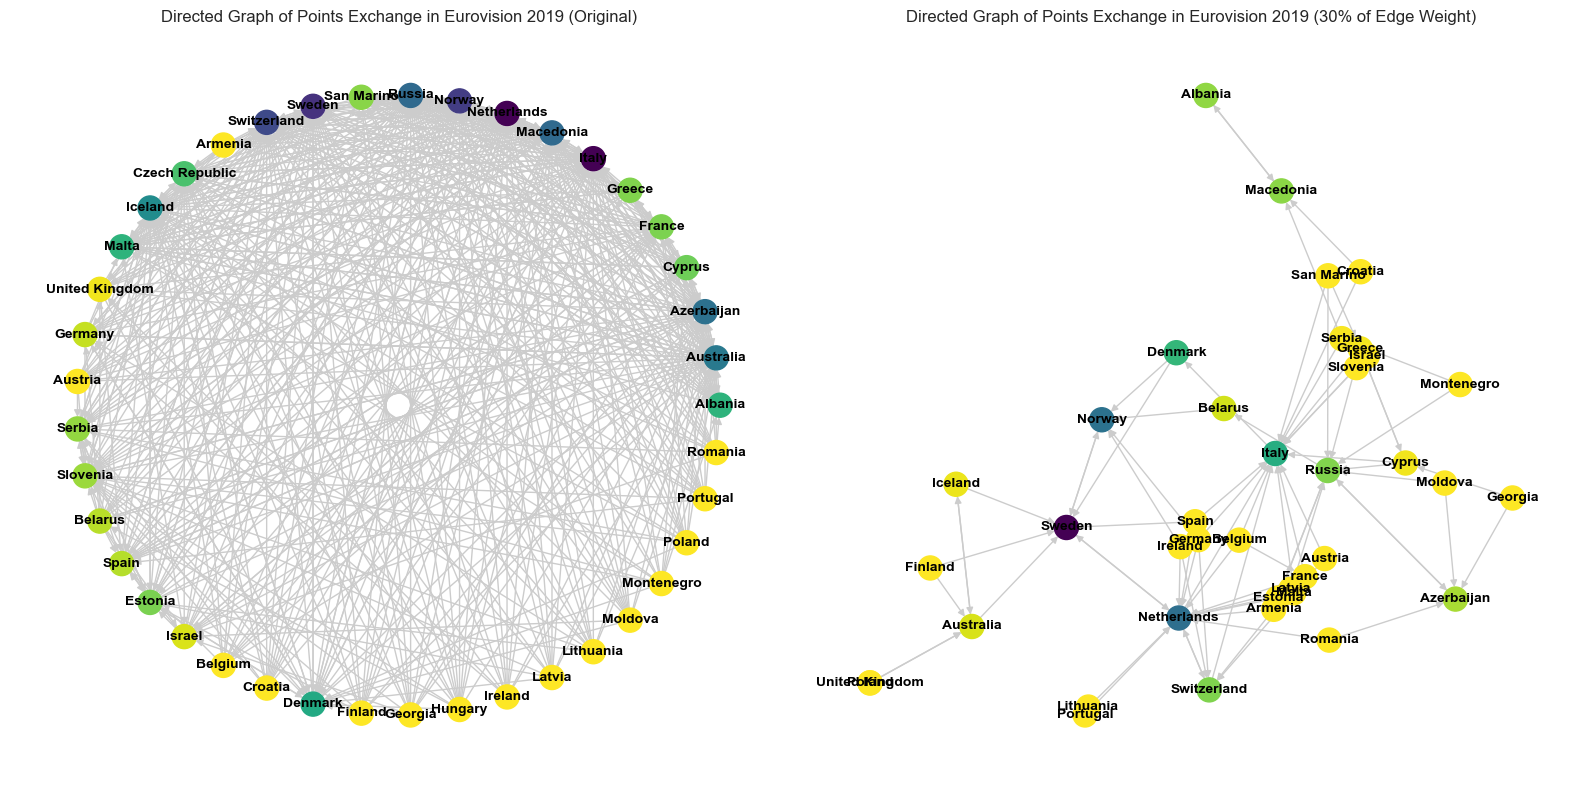

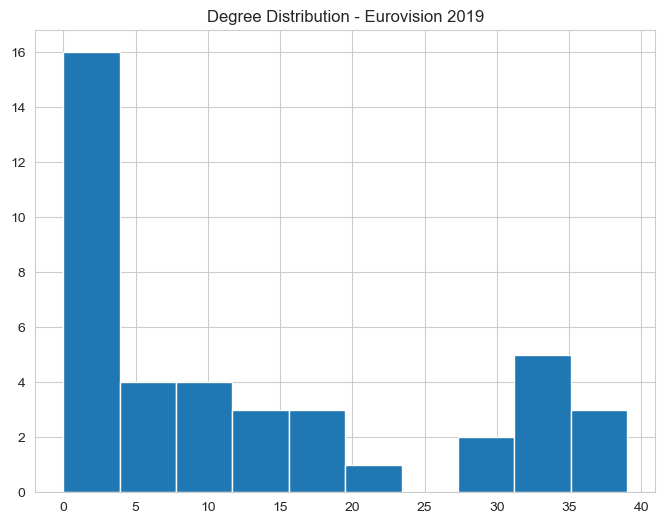

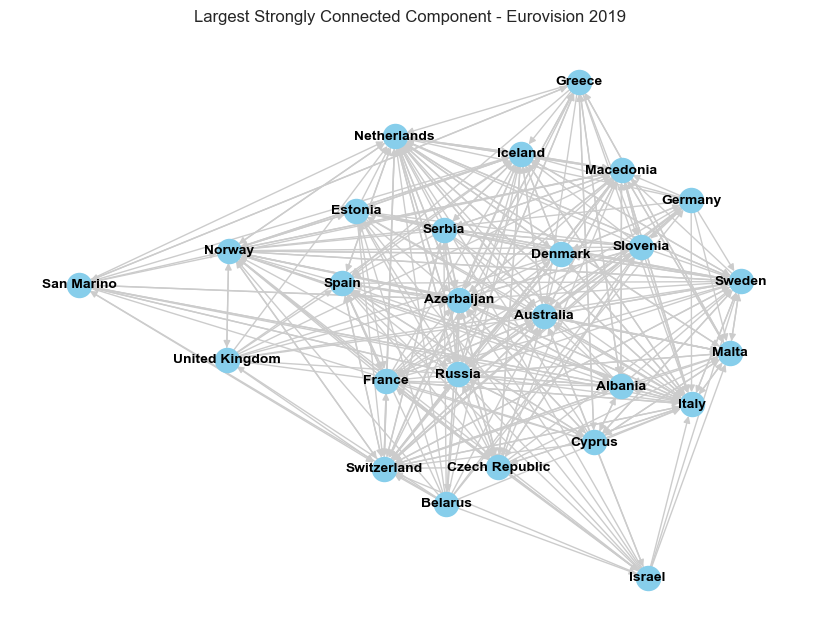

{'nodes': 41,
 'edges': 536,
 'density': 0.32682926829268294,
 'in_degree': InDegreeView({'Albania': 11, 'Australia': 35, 'Azerbaijan': 35, 'Cyprus': 11, 'France': 19, 'Greece': 7, 'Italy': 36, 'Macedonia': 31, 'Netherlands': 39, 'Norway': 35, 'Russia': 35, 'San Marino': 11, 'Sweden': 31, 'Switzerland': 38, 'Armenia': 0, 'Czech Republic': 22, 'Iceland': 33, 'Malta': 15, 'United Kingdom': 5, 'Germany': 6, 'Austria': 0, 'Serbia': 12, 'Slovenia': 19, 'Belarus': 3, 'Spain': 12, 'Estonia': 11, 'Israel': 7, 'Belgium': 0, 'Croatia': 0, 'Denmark': 17, 'Finland': 0, 'Georgia': 0, 'Hungary': 0, 'Ireland': 0, 'Latvia': 0, 'Lithuania': 0, 'Moldova': 0, 'Montenegro': 0, 'Poland': 0, 'Portugal': 0, 'Romania': 0}),
 'page_rank': {'Albania': 0.0319253386225071,
  'Australia': 0.051529839404953835,
  'Azerbaijan': 0.054250343666662766,
  'Cyprus': 0.021268269246749325,
  'France': 0.01958388297276664,
  'Greece': 0.018964203473161793,
  'Italy': 0.08389407273625639,
  'Macedonia': 0.05654089665644793,


In [30]:
# Metricas de la red para el año 2019
df_19, edges_19, G_19, Gedges_19, metricas_19 = network_metrics(df2, 2019)
metricas_19

* La red tiene $n=41$ **nodos** (número de países que participaron) y $m=536$ **enlaces** 

* El **grado** que se tiene en cuenta es el **grado de entrada**, dado que el ganador se determina según qué país ha recibido más votos. Por lo tanto, el país con el mayor grado de entrada es Netherlands, con un grado de 39. En cuanto a la distribución de grado, se observa que hay muchos nodos con un grado bajo, pero se aprecia un incremento notable para valores más altos del grado. Este patrón coincide con los países que han ocupado posiciones destacadas en la competencia.

* La **densidad** de la red es $\rho = \frac{m}{\binom{N}{2}} = 0.3268$. Se trata de una medida de la cantidad de conexiones presentens en relaicón con la mantidad máxima posible. En este caso, vemos que la densidad es menor, dado que la red no está completamente conectada.

* El **page rank** mide la importancia relativa de un nodo en una red dirigida, teniendo en cuenta la estructura de enlaces entrantes y salientes en la red. En este caso, el país con mayor Page Rank es nuevamente Holanda con un valor de $ 0.08386376958658438$.

* Aunque la red no está completamente conectada, el **diámetro** de su componente gigante es de $3$. Además, presenta un coeficiente de clustering de $0.58$ y una longitud media de camino de $1.48$. Esto indica que la red exhibe la propiedad de "mundo pequeño", lo que significa que la mayoría de los nodos pueden alcanzarse desde cualquier otro nodo en solo unos pocos pasos.

* **Centralidad de intermediación**: Una medida de la importancia de un nodo en la red, calculada en función de la cantidad de caminos más cortos que pasan a través de ese nodo. En este caso, el país con mayor centralidad de intermediación es Azerbayan. Esto puede indicar que posee una mayor neutralidiad en el concurso. Ver [Figura 1](#figura-1)

* **Centraldiad de cercanía**: Evalúa la importancia de un nodo en una red, basada en la inversa de la suma de las distancias más cortas entre ese nodo y todos los demás nodos de la red. Holanda destaca nuevamente como el país con la mayor centralidad de cercanía. Este resultado es comprensible, ya que al ser la ganadora de la edición, es probable que muchos países hayan emitido votos hacia Holanda, lo que facilitaría su conexión con otros nodos en la red. Ver [Figura 2](#figura-2)

* **Transitividad**: Se refiere a la proporción de triángulos cerrados en la red, lo que indica en qué medida los nodos tienden a formar grupos o comunidades. En este caso, observamos una alta transitividad de $0.71$, lo que sugiere que hay muchos patrones de 3 nodos que votan entre sí. Este aspecto será analizado con mayor detalle en el estudio de comunidades.

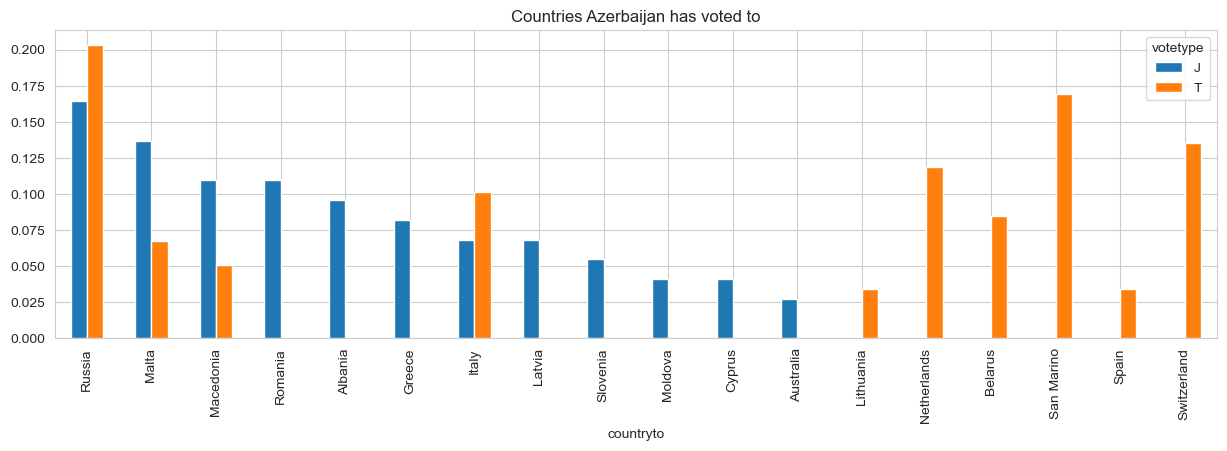

In [31]:
# Centralidad de intermediacion - Votaciones Azerbaijan
df2 \
    .query('year == 2019 and countryfrom=="Azerbaijan"')\
    .pivot_table(index='countryto',columns='votetype', values='points',aggfunc='sum').fillna(0).sort_values('J',ascending=False)\
    .apply(lambda x: x/x.sum(), axis=0)\
    .plot(kind='bar',stacked=False,figsize=(15,4), title='Countries Azerbaijan has voted to');
plt.grid('off')
plt.show();

<div style="text-align: center;">
Figura 1. 
</div>   
<a name="figura-1"></a>

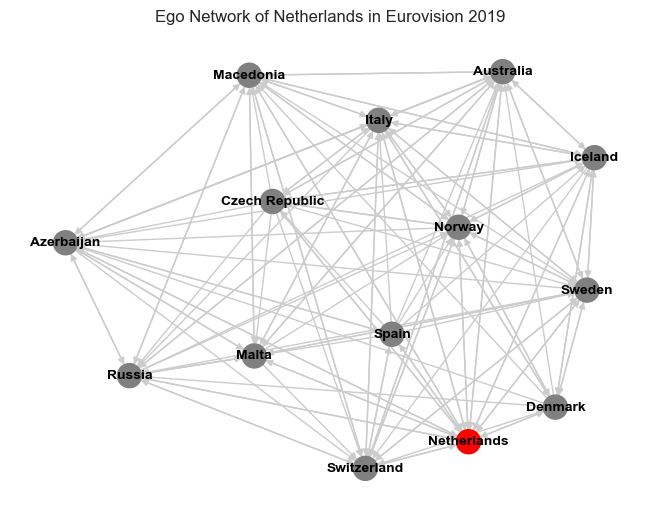

In [32]:
# Red Ego de Holanda
ego_network = G_19.subgraph(nx.ego_graph(G_19, 'Netherlands'))
pos_ego = nx.spring_layout(ego_network) 

# Crear diccionario de colores
node_colors = ['red' if node == 'Netherlands' else 'gray' for node in ego_network.nodes()]

nx.draw(ego_network, pos_ego, with_labels=True, node_color=node_colors,
        edge_color='#cccccc', font_color='#000', font_size=10, font_weight='bold', arrows=True)
plt.title('Ego Network of Netherlands in Eurovision 2019')
plt.axis('off')
plt.show()

<div style="text-align: center;">
Figura 2. 
</div>   
<a name="figura-2"></a>

**Métricas para 2000 hasta 2019**

In [33]:
# Crear un diccionario para almacenar las métricas para cada año
metrics_per_year = {}

# Iterar sobre los años de 2000 a 2019
for year in range(2000, 2020):
    print(f"Calculando métricas para Eurovision {year}...")
    _,_,_,_, metrics_per_year[year] = network_metrics(df2, year, show_plots = False)

Calculando métricas para Eurovision 2000...
Calculando métricas para Eurovision 2001...
Calculando métricas para Eurovision 2002...
Calculando métricas para Eurovision 2003...
Calculando métricas para Eurovision 2004...
Calculando métricas para Eurovision 2005...
Calculando métricas para Eurovision 2006...
Calculando métricas para Eurovision 2007...
Calculando métricas para Eurovision 2008...
Calculando métricas para Eurovision 2009...
Calculando métricas para Eurovision 2010...
Calculando métricas para Eurovision 2011...
Calculando métricas para Eurovision 2012...
Calculando métricas para Eurovision 2013...
Calculando métricas para Eurovision 2014...
Calculando métricas para Eurovision 2015...
Calculando métricas para Eurovision 2016...
Calculando métricas para Eurovision 2017...
Calculando métricas para Eurovision 2018...
Calculando métricas para Eurovision 2019...


Para estudiar las variaciones en las métricas de los grafos creados para los años comprendidos entre 2000 y 2019, se realiza un análisis comparativo de las métricas a lo largo de estos años.

**Visualización de tendencias temporales:** Se emplean gráficos de líneas o gráficos de barras para visualizar cómo varían las métricas a lo largo de los años. Cada métrica se representa como una serie temporal, con el año en el eje x y el valor de la métrica en el eje y.

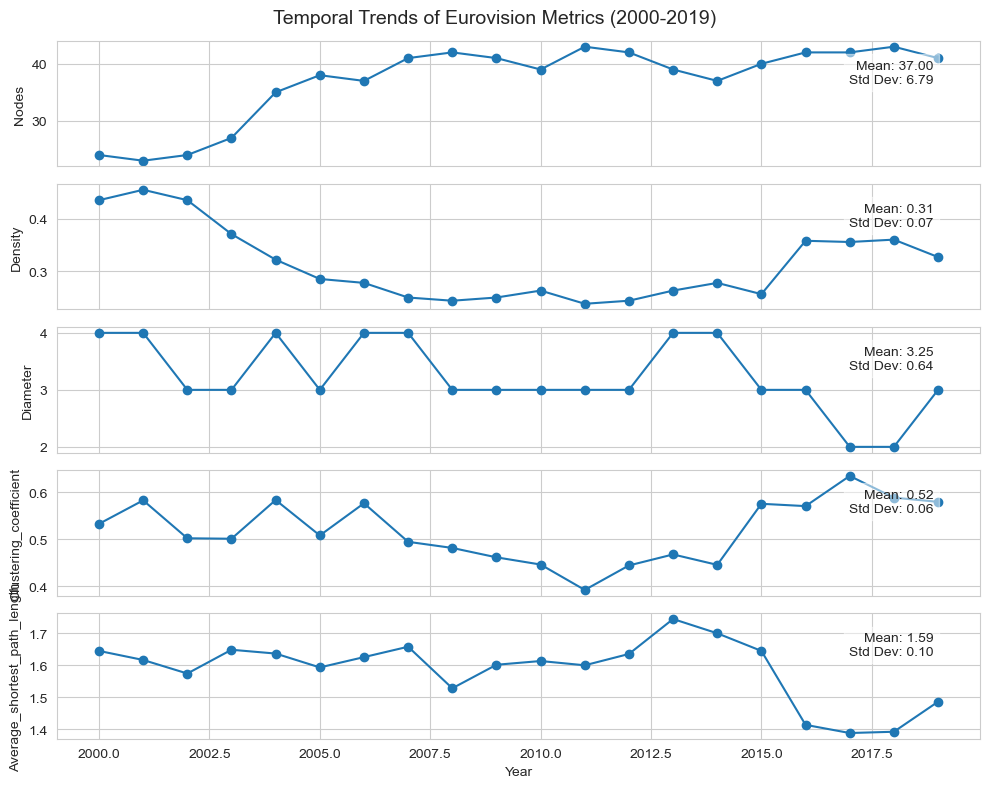

In [34]:
# List of years
years = list(metrics_per_year.keys())

# List of metrics
metrics = ['nodes', 'density', 'diameter','clustering_coefficient', 'average_shortest_path_length'] 

# Create subplots for each metric
fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 8), sharex=True)

# Iterate over each metric and create a line plot for that metric
for i, metric in enumerate(metrics):
    metric_values = [metrics_per_year[year][metric] for year in years]
    axs[i].plot(years, metric_values, marker='o', linestyle='-')
    axs[i].set_ylabel(metric.capitalize())  # Set the metric name on the y-axis
    axs[i].grid(True)
    
    # Calculate descriptive statistics
    metric_data = pd.Series(metric_values)
    mean_value = metric_data.mean()
    std_value = metric_data.std()
    stats_text = f"Mean: {mean_value:.2f}\nStd Dev: {std_value:.2f}"
    
    # Add descriptive statistics as text on the plot
    axs[i].text(0.95, 0.85, stats_text, verticalalignment='top', horizontalalignment='right',
                transform=axs[i].transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Add title and labels to the plot
fig.suptitle('Temporal Trends of Eurovision Metrics (2000-2019)', fontsize=14)
plt.xlabel('Year')
plt.tight_layout()
plt.show()

Con esto, podemos concluir que se trata de una red de **mundo pequeño**, ya que presenta características típicas de este tipo de redes. Por un lado, el diámetro es relativamente pequeño, variando entre $4$ y $2$, lo que indica que la mayoría de los nodos están a pocas conexiones de distancia entre sí. Además, observamos un coeficiente de clustering generalmente alto, con un valor medio de $0.52$. Este coeficiente indica que los nodos tienden a formar grupos densamente interconectados en la red. Por otro lado, el camino más corto promedio entre todos los pares de nodos en la red es $1.59$, lo que confirma la naturaleza de mundo pequeño de la red, donde la mayoría de los nodos están muy cercanos entre sí en términos de conexiones.

Por otra parte, estudiamos la distribución de grado para ver si es libre de escala o sigue una ley de potencias.

### 4.2. Modelos de formación de redes <a name="modelos-formacion-redes"></a>

Tras estudiar las métricas de la red,  se procede a realizar una comparación con algunos modelos base de formación de redes aleatorias. El objetivo es evaluar si las características observadas en la red, como el diámetro, la densidad, el coeficiente de clustering y la longitud promedio del camino más corto, son consistentes con lo que se esperaría en redes generadas aleatoriamente. Esto nos ayudará a entender si la red exhibe patrones estructurales significativos o si se asemeja más a una red aleatoria en términos de estas métricas.

In [35]:
# Generar una red de Erdős-Rényi con la misma cantidad de nodos y enlaces
def generate_er_random_network(original_network):
    num_nodes = len(original_network.nodes)
    density = nx.density(original_network)
    return nx.erdos_renyi_graph(num_nodes, density)

# Función para calcular métricas en una red
def calculate_metrics(network):
    diameter = nx.diameter(network)
    clustering_coefficient = nx.average_clustering(network)
    average_shortest_path_length = nx.average_shortest_path_length(network)
    return diameter, clustering_coefficient, average_shortest_path_length

In [36]:
# Generar una red de Erdős-Rényi
er_random_network = generate_er_random_network(G_19)
er_random_diameter, er_random_clustering_coefficient, er_random_average_shortest_path_length = calculate_metrics(er_random_network)

# Metricas
print("Diameter:", er_random_diameter)
print("Clustering Coefficient:", er_random_clustering_coefficient)
print("Average Shortest Path Length:", er_random_average_shortest_path_length)

Diameter: 3
Clustering Coefficient: 0.3175333425918641
Average Shortest Path Length: 1.6670731707317072


Con esto, podemos concluir que al red es de mundo pequeño.

**Por hacer** Mirar ladistribucion de grado de la red aleatoria

### 4.3. Análisis de comunidades <a name="analisis-de-comunidades"></a>

####  4.3.1 Estudio de patrones

In [38]:
# Grafo
df_19, edges_19, G_19, Gedges_19 = plot_eurovision_graph(df2, 2019, percent=0.3, show_plots = False)  

Detección de patrones de 3 nodos

1. **Identificar triangulos:** Puedes usar la función `nx.triangles(G)` de NetworkX para calcular el número de triángulos que cada nodo forma en una red G. Esto te dará un diccionario donde las claves son los nodos y los valores son el número de triángulos en los que participa cada nodo.

In [39]:
# Calcular el numero de triangulos para cada nodo
nx.triangles(G_19.to_undirected()) # Convertir el grafo dirigido en uno no dirigido

{'Albania': 96,
 'Australia': 334,
 'Azerbaijan': 348,
 'Cyprus': 101,
 'France': 229,
 'Greece': 72,
 'Italy': 369,
 'Macedonia': 289,
 'Netherlands': 385,
 'Norway': 346,
 'Russia': 386,
 'San Marino': 93,
 'Sweden': 318,
 'Switzerland': 373,
 'Armenia': 61,
 'Czech Republic': 252,
 'Iceland': 326,
 'Malta': 111,
 'United Kingdom': 99,
 'Germany': 100,
 'Austria': 90,
 'Serbia': 161,
 'Slovenia': 245,
 'Belarus': 106,
 'Spain': 134,
 'Estonia': 143,
 'Israel': 118,
 'Belgium': 59,
 'Croatia': 72,
 'Denmark': 170,
 'Finland': 77,
 'Georgia': 75,
 'Hungary': 92,
 'Ireland': 63,
 'Latvia': 76,
 'Lithuania': 75,
 'Moldova': 70,
 'Montenegro': 60,
 'Poland': 85,
 'Portugal': 89,
 'Romania': 71}

2. **Identificar triángulos globales:** Para contar el número total de triángulos en una red, puedes usar la función `nx.triadic_census(G)`, que devuelve un diccionario que cuenta los diferentes tipos de triángulos en la red.

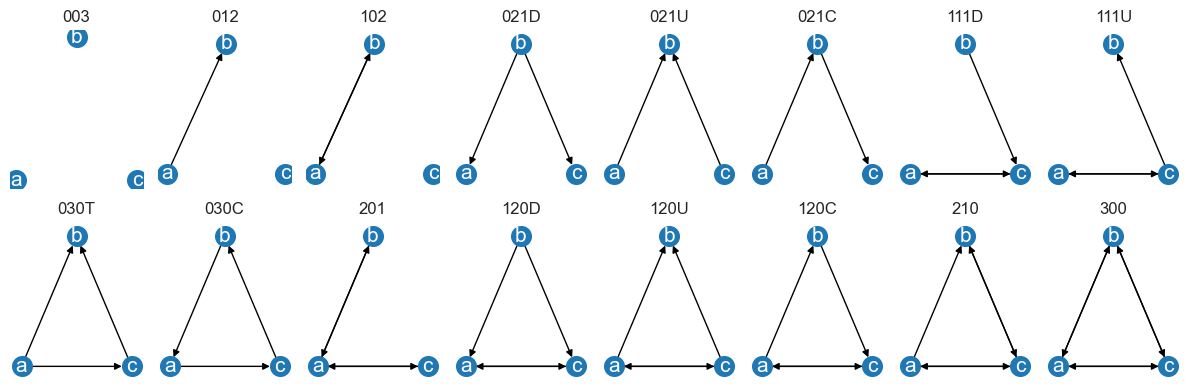

In [40]:
nColumns=8;
fig, axs = plt.subplots(int(np.ceil(len(nx.algorithms.triads.TRIAD_NAMES)/nColumns)), nColumns, figsize=(12,4))

for i,k in enumerate(list(nx.algorithms.triads.TRIAD_NAMES)):
    ax = axs[i//nColumns, i%nColumns]
    ax.set_title(f'{k}');
    nx.draw(nx.triad_graph(k), pos={'a':[0,0],'c':[10,0],'b':[5,10*np.sqrt(3)/2]},
            node_size=200, font_size=15,font_color='white', with_labels=True,ax=ax);

ax.set_facecolor('#cccccc');
plt.tight_layout();

In [41]:
nx.triadic_census(G_19) # En la red total

{'003': 2035,
 '012': 2115,
 '102': 365,
 '021D': 135,
 '021U': 2230,
 '021C': 285,
 '111D': 1065,
 '111U': 75,
 '030T': 689,
 '030C': 13,
 '201': 82,
 '120D': 890,
 '120U': 86,
 '120C': 122,
 '210': 325,
 '300': 148}

In [42]:
nx.triadic_census(Gedges_19) # en la red con el porcentaje seleccionado

{'003': 6953,
 '012': 1646,
 '102': 195,
 '021D': 18,
 '021U': 212,
 '021C': 41,
 '111D': 48,
 '111U': 2,
 '030T': 12,
 '030C': 0,
 '201': 2,
 '120D': 6,
 '120U': 4,
 '120C': 0,
 '210': 0,
 '300': 0}

#### 4.3.2. Detección de comunidades

Detectar comunidades en una red es esencial para comprender su estructura y dinámica. El objetivo principal radica en dividir la red en grupos disjuntos, de modo que los enlaces que los conecten sean menos de los esperados.

**Label Propagation (Propagación de Etiquetas):**

* Procedimiento: Se construyen redes aleatorias con el mismo número de nodos y enlaces que la red en estudio. Luego, se cuenta el número de patrones en estas redes y se calcula el valor de Z para determinar si el número de patrones es significativo.
* Asigna etiquetas de forma aleatoria a los nodos.
* Selecciona la etiqueta más común en el vecindario de cada nodo.
* Este método tiende a agrupar nodos en comunidades grandes.
* Es altamente eficiente en términos de velocidad, pero puede no ser la mejor opción para grafos altamente densos.

**Louvain Modularity (Modularidad de Louvain):**
* Asigna nodos a clústeres de manera exhaustiva con el objetivo de maximizar la cantidad de enlaces dentro de cada clúster.
* Produce clústeres de alta calidad y es altamente eficiente.
* Es especialmente útil para grafos de tamaño mediano a grande.

**Spectral (Espectral):**
* Realiza un Kmeans de la incrustación espectral (vectores y valores propios) de la matriz de Laplacian.
* Está vinculado con los cortes de grafo y es efectivo para detectar comunidades bien definidas.
* Puede ser más costoso computacionalmente que otros métodos, pero tiene el potencial de proporcionar resultados precisos.

In [43]:
def detect_communities(G, comType='louvain', num_communities=10):
    # Generar colores para las comunidades
    colors = [sns.color_palette()[c] for c in range(num_communities)]
    colors = ['#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255)) for (r, g, b) in colors]

    # Detectar las comunidades segun el tipo de algoritmo
    if comType == 'LPA':
        communities = {
            n: colors[i]
            for i, c in enumerate(nx.algorithms.community.label_propagation_communities(nx.Graph(G)))
            for n in list(c)
        }
        
    elif comType == 'louvain':
        partition = louvain.best_partition(nx.Graph(G), random_state=42)
        communities = {c: colors[i] for c, i in partition.items()}
    
    elif comType == 'spectral':
        sc = SpectralClustering(num_communities, affinity='precomputed', n_init=100).fit(nx.to_numpy_matrix(nx.Graph(G)))
        communities = {c: colors[i] for c, i in zip(G.nodes(), sc.labels_)}
    
    else:
        raise ValueError("Tipo de algoritmo de detección de comunidades no válido")

    return communities

In [46]:
# changing the networkx function to draw labels with the same color as the nodes
def draw_networkx_labels(G, pos,
                         labels=None,
                         font_size=12,
                         font_color='k',
                         font_family='sans-serif',
                         font_weight='normal',
                         alpha=1.0,
                         bbox=None,
                        pos_shift = 0,
                         ax=None,
                         **kwds):
    
    """Draw node labels on the graph G.

    Parameters
    ----------
    G : graph
       A networkx graph

    pos : dictionary
       A dictionary with nodes as keys and positions as values.
       Positions should be sequences of length 2.

    labels : dictionary, optional (default=None)
       Node labels in a dictionary keyed by node of text labels

    font_size : int
       Font size for text labels (default=12)

    font_color : string
       Font color string (default='k' black)

    font_family : string
       Font family (default='sans-serif')

    font_weight : string
       Font weight (default='normal')

    alpha : float
       The text transparency (default=1.0)

    ax : Matplotlib Axes object, optional
       Draw the graph in the specified Matplotlib axes.

    Returns
    -------
    dict
        `dict` of labels keyed on the nodes

    Examples
    --------
    >>> G=nx.dodecahedral_graph()
    >>> labels=nx.draw_networkx_labels(G,pos=nx.spring_layout(G))

    Also see the NetworkX drawing examples at
    http://networkx.github.io/documentation/latest/gallery.html


    See Also
    --------
    draw()
    draw_networkx()
    draw_networkx_nodes()
    draw_networkx_edges()
    draw_networkx_edge_labels()
    """
    try:
        import matplotlib.pyplot as plt
        import matplotlib.cbook as cb
    except ImportError:
        raise ImportError("Matplotlib required for draw()")
    except RuntimeError:
        print("Matplotlib unable to open display")
        raise

    if ax is None:
        ax = plt.gca()

    if labels is None:
        labels = dict((n, n) for n in G.nodes())

    # set optional alignment
    horizontalalignment = kwds.get('horizontalalignment', 'center')
    verticalalignment = kwds.get('verticalalignment', 'center')
    
    if type(font_color) == str:
        font_color = [font_color]*len(labels);

    text_items = {}  # there is no text collection so we'll fake one
    for (n, label),_font_color in zip(labels.items(),font_color):
        (x, y) = pos[n]
        label = str(label)  # this will cause "1" and 1 to be labeled the same
        t = ax.text(x+pos_shift, y+pos_shift,
                  label,
                  size=font_size,
                  color=_font_color,
                  family=font_family,
                  weight=font_weight,
                  horizontalalignment=horizontalalignment,
                  verticalalignment=verticalalignment,
                  transform=ax.transData,
                  bbox=bbox,
                  clip_on=True,
                  )
        text_items[n] = t

    return text_items

In [47]:
def plotESC(G, communities, influence, pos,pos_shift=0):
    eColor = [communities[u] for (u, v, d) in G.edges(data=True)]
    
    nx.draw_networkx_edges(
        G, pos, 
        width=[10*d['weight']+1 for (u, v, d) in G.edges(data=True)],
        alpha=0.2,
        edge_color=eColor);
    
    # nodes
    nx.draw_networkx_nodes(
        G,
        pos,
        linewidths=3,
        nodelist=influence.keys(),
        node_size=[400*v/influenceMax+30 for v in influence.values()],
        node_color=[communities[c] for c in influence.keys()]
    )
    
    draw_networkx_labels(
        G,
        pos,
        pos_shift=pos_shift,
        font_size=10,
        font_weight='bold',
        font_family='sans-serif',
        font_color=[communities[c] for c in influence.keys()]
    )

Ejemplo para año 2019:

In [44]:
# Detectar las comunidades
communities = detect_communities(Gedges_19, comType='louvain')

# Inflencia de un nodo basado en el PageRank
influence = nx.pagerank(Gedges_19,weight='weight')
influenceMax = max(influence.values())

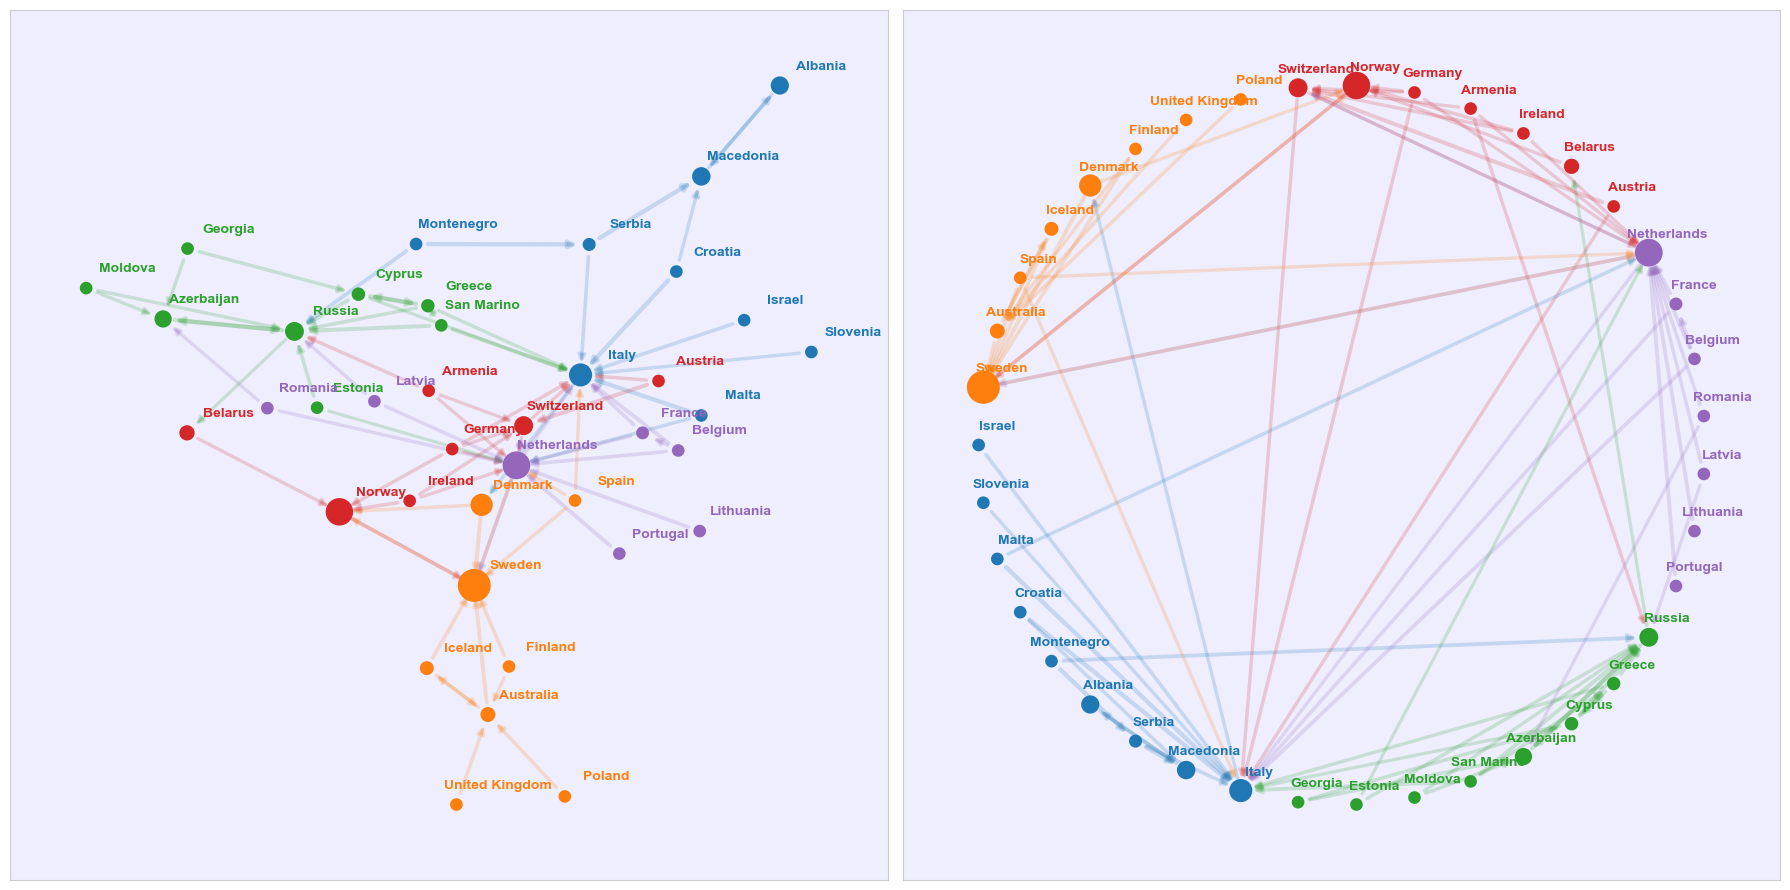

In [48]:
# Graficos por comunidades
# Agregar por comunidad
shells = pd.merge(
    pd.DataFrame(communities.items(), columns=['country','cluster']),
    pd.DataFrame(dict(Gedges_19.degree()).items(), columns=['country','degree'])
).sort_values(['cluster','degree'])['country'].values

# Visualizacion
plt.figure(figsize=(18,9))

plt.subplot(121)
plt.gca().set_facecolor('#eeeeFF');
np.random.seed(42)
pos = nx.layout.fruchterman_reingold_layout(nx.Graph(Gedges_19),k=0.01,iterations=100,scale = 2);
plotESC(Gedges_19, communities, influence, pos,pos_shift=0.1);
plt.grid(False)

plt.subplot(122)
plt.gca().set_facecolor('#eeeeFF');
pos = nx.shell_layout(Gedges_19,nlist=[shells])
plotESC(Gedges_19, communities, influence, pos,pos_shift=0.05);
plt.grid(False)
plt.tight_layout()
plt.show()

Ejemplo para año 2012

In [49]:
# Grafo
df_2012, edges_12, G_12, Gedges_12 = plot_eurovision_graph(df2, 2012, percent=0.3, show_plots = False)  

# Detectar las comunidades
communities = detect_communities(Gedges_12, comType='louvain')

# Inflencia de un nodo basado en el PageRank
influence = nx.pagerank(Gedges_12,weight='weight')
influenceMax = max(influence.values())

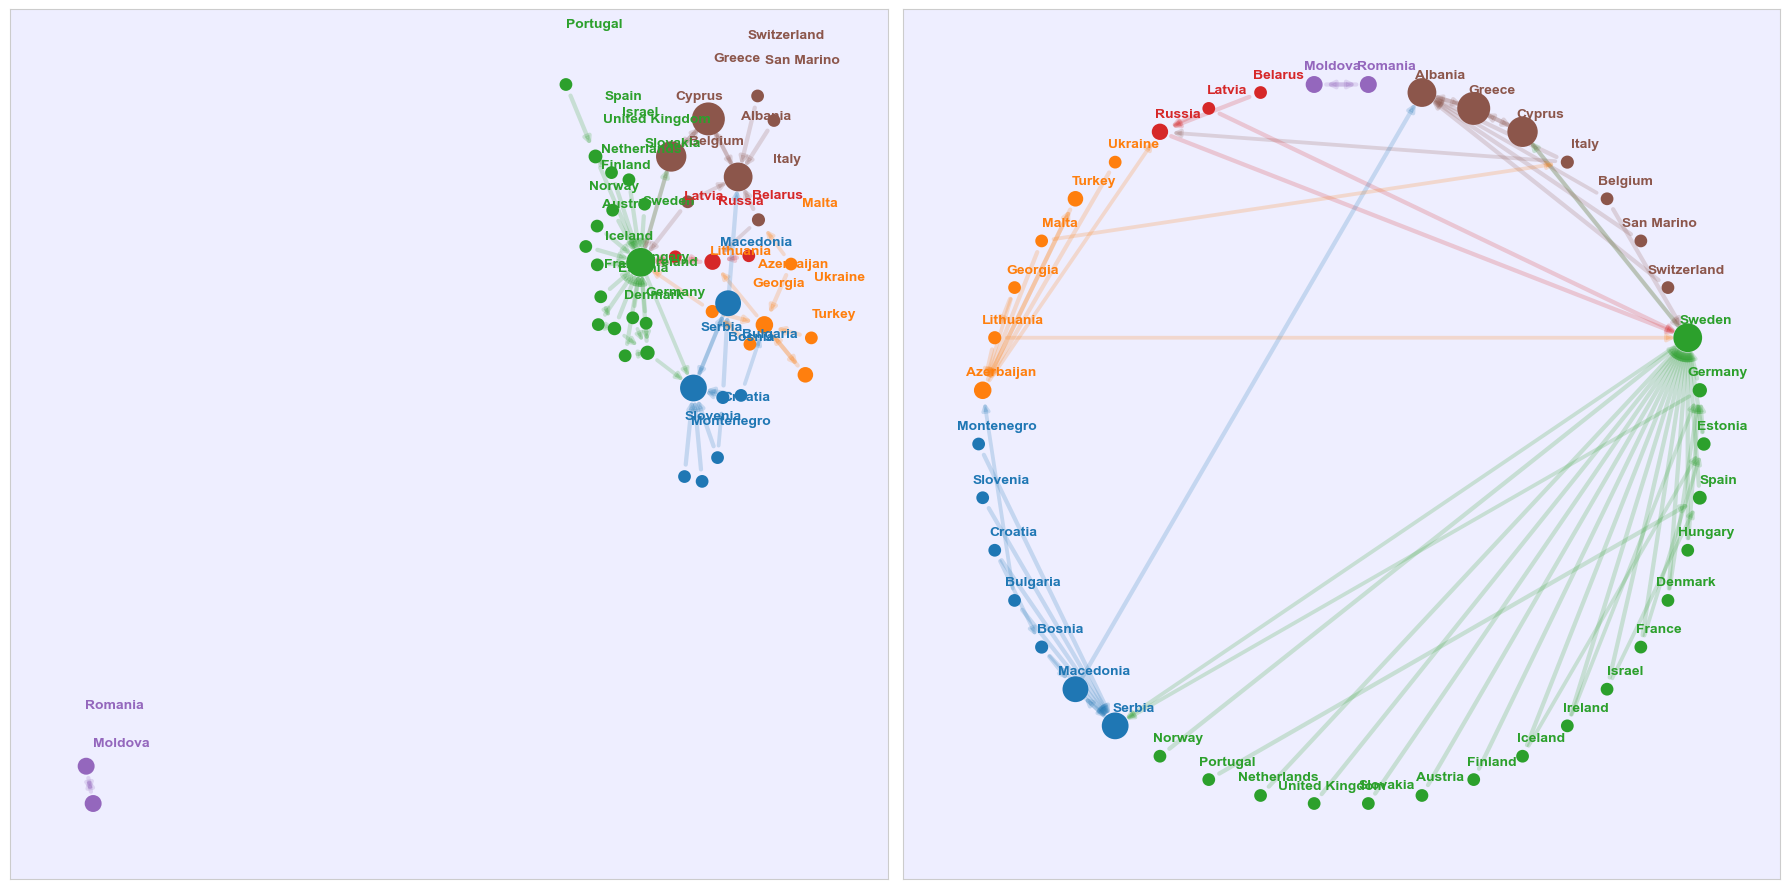

In [50]:
# Graficos por comunidades
# Agregar por comunidad
shells = pd.merge(
    pd.DataFrame(communities.items(), columns=['country','cluster']),
    pd.DataFrame(dict(Gedges_12.degree()).items(), columns=['country','degree'])
).sort_values(['cluster','degree'])['country'].values

# Visualizacion
plt.figure(figsize=(18,9))

plt.subplot(121)
plt.gca().set_facecolor('#eeeeFF');
np.random.seed(42)
pos = nx.layout.fruchterman_reingold_layout(nx.Graph(Gedges_12),k=0.01,iterations=100,scale = 2);
plotESC(Gedges_12, communities, influence, pos,pos_shift=0.1);
plt.grid(False)

plt.subplot(122)
plt.gca().set_facecolor('#eeeeFF');
pos = nx.shell_layout(Gedges_12,nlist=[shells])
plotESC(Gedges_12, communities, influence, pos,pos_shift=0.05);
plt.grid(False)
plt.tight_layout()
plt.show()

Ejemplo para año 2002

In [51]:
# Grafo
df_2002, edges_02, G_02, Gedges_02 = plot_eurovision_graph(df2, 2002, percent=0.3, show_plots = False)  

# Detectar las comunidades
communities = detect_communities(Gedges_02, comType='louvain')

# Inflencia de un nodo basado en el PageRank
influence = nx.pagerank(Gedges_02,weight='weight')
influenceMax = max(influence.values())

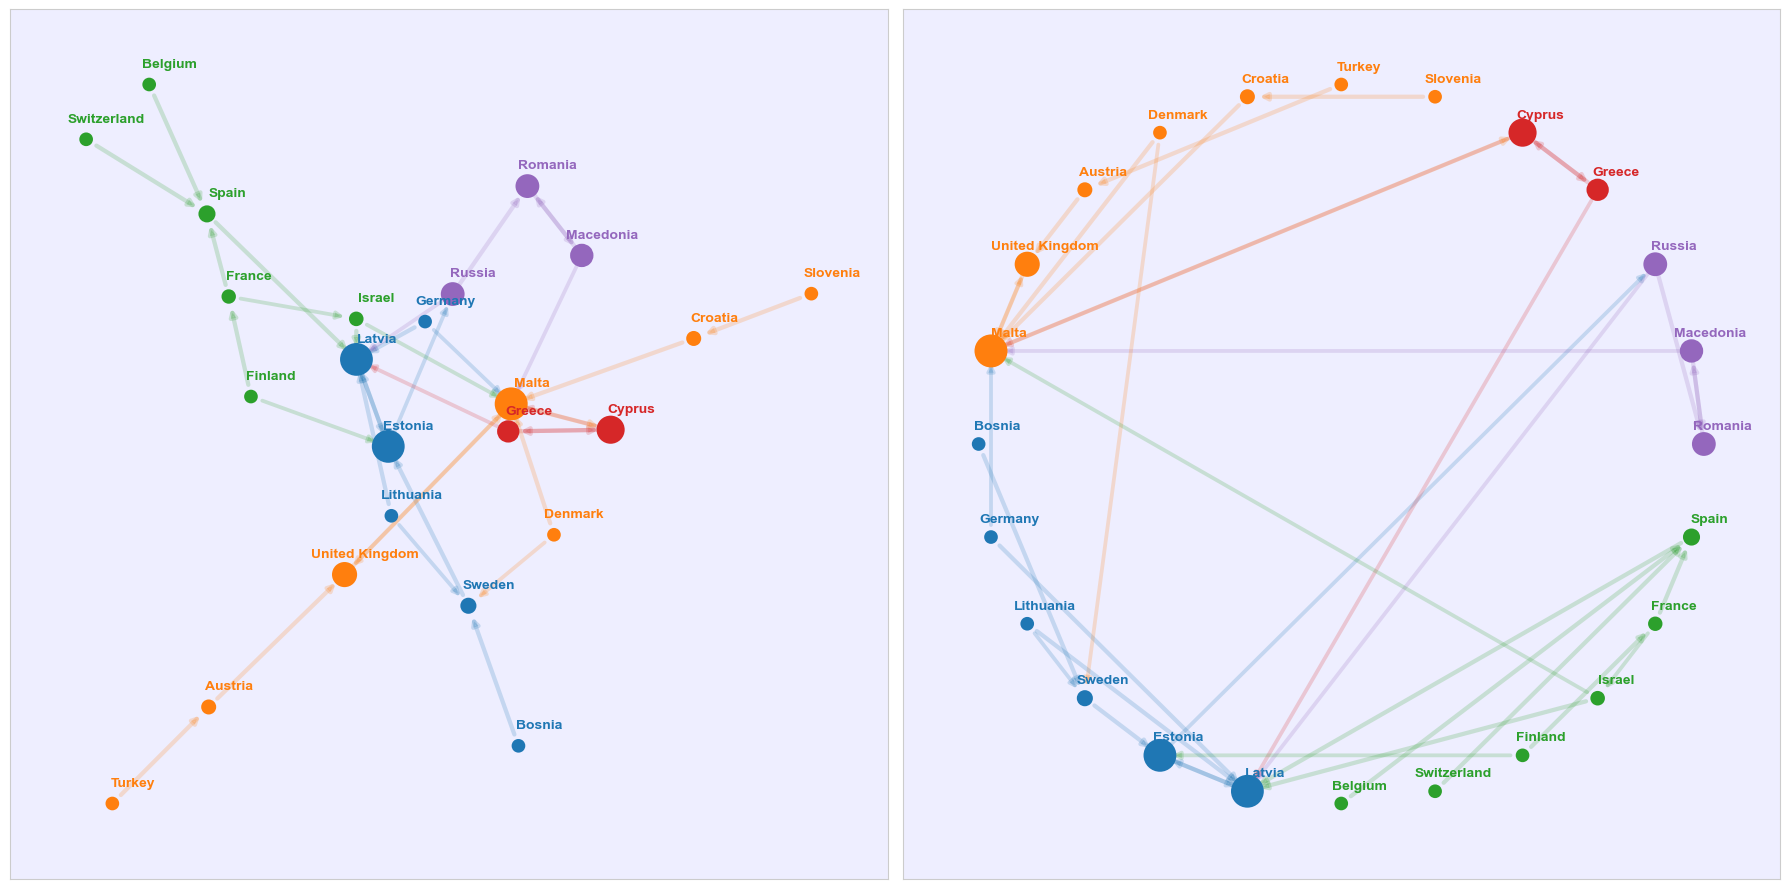

In [52]:
# Graficos por comunidades
# Agregar por comunidad
shells = pd.merge(
    pd.DataFrame(communities.items(), columns=['country','cluster']),
    pd.DataFrame(dict(Gedges_02.degree()).items(), columns=['country','degree'])
).sort_values(['cluster','degree'])['country'].values

# Visualizacion
plt.figure(figsize=(18,9))

plt.subplot(121)
plt.gca().set_facecolor('#eeeeFF');
np.random.seed(42)
pos = nx.layout.fruchterman_reingold_layout(nx.Graph(Gedges_02),k=0.01,iterations=100,scale = 2);
plotESC(Gedges_02, communities, influence, pos,pos_shift=0.1);
plt.grid(False)

plt.subplot(122)
plt.gca().set_facecolor('#eeeeFF');
pos = nx.shell_layout(Gedges_02,nlist=[shells])
plotESC(Gedges_02, communities, influence, pos,pos_shift=0.05);
plt.grid(False)
plt.tight_layout()
plt.show()

### 4. 4. Evolución y dinámica <a name="evolucion-y-dinamica"></a>

## 5. Visualización mediante geolocalización <a name="visualizacion-mediante-geolocalizacion"></a>

## 6. Conclusiones <a name="conclusiones"></a>

## Bibliografía <a name="bibliografia"></a>

[1] Charron, N. (2013). Impartiality, friendship-networks and voting behavior: Evidence from voting patterns in the Eurovision Song Contest 

[2] Custodio, E. (2020). Network Analysis applied to Eurovision